In [1]:
import numpy as np
import torch
import os
from math import ceil
import copy
import matplotlib.pyplot as plt

c:\Users\relra\Documents\Xiao\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
from functools import partial
from collections import OrderedDict
from typing import Optional, Callable
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F

# Define basic architectures
- fully connected networks
- - Fully Connected Networks are easy to scale up, we don't need to re-design the architecture
- - In order to efficiently scale up convolutional neural networks, we determine to use efficentNet to scale up the networks

## FC

In [3]:
import torch
from torch import nn

class fc(nn.Module):  # only for mnist
  def __init__(self,n_layers,n_neurons,n_classes):
    super(fc, self).__init__()

    assert n_layers > 0, "layers must be positive integer"
    assert n_neurons > 0, "layers must be positive integer"

    layers = []
    layers.append(nn.Linear(28*28, n_neurons))  # first layer should match mnist image sizes
    layers.append(nn.ReLU())    # we can add BN and dropout layer here, TBD
    for i in range(n_layers-1):
      layers.append(nn.Linear(n_neurons,n_neurons))
      layers.append(nn.ReLU())  # we can add BN and dropout layer here, TBD
    layers.append(nn.Linear(n_neurons,n_classes))
    
    self.classifier = nn.Sequential(*layers)
  
  def forward(self,x):
    x = x.view(x.size(0),-1)  # reshape the input x
    y = self.classifier(x)
    return y

## LeNet

In [4]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits

## Efficient Net
- Squeeze and Excitation Layer
- MBConv 
- Efficient Net 

In [5]:
def _make_divisible(ch, divisor=8, min_ch=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch

"""

"""
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf

    This function is taken from the rwightman.
    It can be seen here:
    https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py#L140
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

"""

"""
class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

###Define Conv BN and Active function


In [6]:
class ConvBNActivation(nn.Sequential):
    def __init__(self,
                 in_planes: int,
                 out_planes: int,
                 kernel_size: int = 3,
                 stride: int = 1,
                 groups: int = 1,
                 norm_layer: Optional[Callable[..., nn.Module]] = None, #BN，default as None
                 activation_layer: Optional[Callable[..., nn.Module]] = None): #ac，default as None
        padding = (kernel_size - 1) // 2
        if norm_layer is None: #if there is no other norm_layer, use BN
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:  # That;s the default one for activation
            activation_layer = nn.SiLU  # alias Swish function (torch>=1.7)

        #define layer struc[in_channels,out_channels,kernel_size,stride,padding,groups,bias=False],-->BN-->ac
        super(ConvBNActivation, self).__init__(nn.Conv2d(in_channels=in_planes,
                                                         out_channels=out_planes,
                                                         kernel_size=kernel_size,
                                                         stride=stride,
                                                         padding=padding,
                                                         groups=groups,
                                                         bias=False),
                                               norm_layer(out_planes),
                                               activation_layer())


### Define Squeeze Excitation module

In [7]:
class SqueezeExcitation(nn.Module):
    def __init__(self,
                 input_c: int,   # block input channel
                 expand_c: int,  # block expand channel
                 squeeze_factor: int = 4):
        super(SqueezeExcitation, self).__init__()
        squeeze_c = input_c // squeeze_factor
        self.fc1 = nn.Conv2d(expand_c, squeeze_c, 1)
        self.ac1 = nn.SiLU()  # alias Swish
        self.fc2 = nn.Conv2d(squeeze_c, expand_c, 1)
        self.ac2 = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        scale = F.adaptive_avg_pool2d(x, output_size=(1, 1))
        scale = self.fc1(scale)
        scale = self.ac1(scale)
        scale = self.fc2(scale)
        scale = self.ac2(scale)
        return scale * x



### MBConv module

In [8]:

"""
The Config that is similar to mobilenetV3
""" 
class InvertedResidualConfig:  
    # kernel_size, in_channel, out_channel, exp_ratio, strides, use_SE, drop_connect_rate
    def __init__(self,
                 kernel: int,          # 3 or 5
                 input_c: int,
                 out_c: int,
                 expanded_ratio: int,  # 1 or 6
                 stride: int,          # 1 or 2
                 use_se: bool,         # True
                 drop_rate: float,
                 index: str,           # 1a, 2a, 2b, ...
                 width_coefficient: float):
        self.input_c = self.adjust_channels(input_c, width_coefficient)
        self.kernel = kernel
        self.expanded_c = self.input_c * expanded_ratio
        self.out_c = self.adjust_channels(out_c, width_coefficient)
        self.use_se = use_se
        self.stride = stride
        self.drop_rate = drop_rate
        self.index = index

    @staticmethod
    def adjust_channels(channels: int, width_coefficient: float):
        return _make_divisible(channels * width_coefficient, 8)

"""
Real MBC Conv module
"""
class InvertedResidual(nn.Module):
    def __init__(self,
                 cnf: InvertedResidualConfig, #input the config
                 norm_layer: Callable[..., nn.Module]): #BN Struc 
        super(InvertedResidual, self).__init__()

        if cnf.stride not in [1, 2]: #determine if stride is within 1 or not
            raise ValueError("illegal stride value.")

        self.use_res_connect = (cnf.stride == 1 and cnf.input_c == cnf.out_c)

        layers = OrderedDict()     #make a Dic t build MBConv struc 
        activation_layer = nn.SiLU  # alias Swish

        # expand.  
        # build the first 1x1 layer, be careful there is no need for 1x1 layer when n=1
        if cnf.expanded_c != cnf.input_c: #when this expend_C = input_c, which is n=1, skip
            layers.update({"expand_conv": ConvBNActivation(cnf.input_c,
                                                           cnf.expanded_c,
                                                           kernel_size=1,
                                                           norm_layer=norm_layer,
                                                           activation_layer=activation_layer)})

        # depthwise
        layers.update({"dwconv": ConvBNActivation(cnf.expanded_c,
                                                  cnf.expanded_c,
                                                  kernel_size=cnf.kernel,
                                                  stride=cnf.stride,
                                                  groups=cnf.expanded_c,
                                                  norm_layer=norm_layer,
                                                  activation_layer=activation_layer)})

        if cnf.use_se:
            layers.update({"se": SqueezeExcitation(cnf.input_c,
                                                   cnf.expanded_c)})

        # project
        layers.update({"project_conv": ConvBNActivation(cnf.expanded_c,
                                                        cnf.out_c,
                                                        kernel_size=1,
                                                        norm_layer=norm_layer,
                                                        activation_layer=nn.Identity)})

        self.block = nn.Sequential(layers)
        self.out_channels = cnf.out_c
        self.is_strided = cnf.stride > 1

        # 只有在使用shortcut连接时才使用dropout层
        if self.use_res_connect and cnf.drop_rate > 0:
            self.dropout = DropPath(cnf.drop_rate)
        else:
            self.dropout = nn.Identity()

    def forward(self, x: Tensor) -> Tensor:
        result = self.block(x)
        result = self.dropout(result)
        if self.use_res_connect:
            result += x

        return result

### EfficientNet Model

In [9]:
 
class EfficientNet(nn.Module):  
    def __init__(self,
                 width_coefficient: float,  
                 depth_coefficient: float,
                 num_classes: int = 1000,
                 dropout_rate: float = 0.2,
                 drop_connect_rate: float = 0.2,
                 block: Optional[Callable[..., nn.Module]] = None,
                 norm_layer: Optional[Callable[..., nn.Module]] = None
                 ):
        super(EfficientNet, self).__init__()

        # kernel_size, in_channel, out_channel, exp_ratio, strides, use_SE, drop_connect_rate, repeats
        default_cnf = [[3, 32, 16, 1, 1, True, drop_connect_rate, 1],
                       [3, 16, 24, 6, 2, True, drop_connect_rate, 2],
                       [5, 24, 40, 6, 2, True, drop_connect_rate, 2],
                       [3, 40, 80, 6, 2, True, drop_connect_rate, 3],
                       [5, 80, 112, 6, 1, True, drop_connect_rate, 3],
                       [5, 112, 192, 6, 2, True, drop_connect_rate, 4],
                       [3, 192, 320, 6, 1, True, drop_connect_rate, 1]]

        def round_repeats(repeats):
            """Round number of repeats based on depth multiplier."""
            return int(math.ceil(depth_coefficient * repeats))

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=1e-3, momentum=0.1)

        adjust_channels = partial(InvertedResidualConfig.adjust_channels,
                                  width_coefficient=width_coefficient)

        # build inverted_residual_setting
        bneck_conf = partial(InvertedResidualConfig,
                             width_coefficient=width_coefficient)

        b = 0
        num_blocks = float(sum(round_repeats(i[-1]) for i in default_cnf))
        inverted_residual_setting = []
        for stage, args in enumerate(default_cnf):
            cnf = copy.copy(args)
            for i in range(round_repeats(cnf.pop(-1))):
                if i > 0:
                    # strides equal 1 except first cnf
                    cnf[-3] = 1  # strides
                    cnf[1] = cnf[2]  # input_channel equal output_channel

                cnf[-1] = args[-2] * b / num_blocks  # update dropout ratio
                index = str(stage + 1) + chr(i + 97)  # 1a, 2a, 2b, ...
                inverted_residual_setting.append(bneck_conf(*cnf, index))
                b += 1

        # create layers
        layers = OrderedDict()

        # first conv
        layers.update({"stem_conv": ConvBNActivation(in_planes=3,
                                                     out_planes=adjust_channels(32),
                                                     kernel_size=3,
                                                     stride=2,
                                                     norm_layer=norm_layer)})

        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.update({cnf.index: block(cnf, norm_layer)})

        # build top
        last_conv_input_c = inverted_residual_setting[-1].out_c
        last_conv_output_c = adjust_channels(1280)
        layers.update({"top": ConvBNActivation(in_planes=last_conv_input_c,
                                               out_planes=last_conv_output_c,
                                               kernel_size=1,
                                               norm_layer=norm_layer)})

        self.features = nn.Sequential(layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        classifier = []
        if dropout_rate > 0:
            classifier.append(nn.Dropout(p=dropout_rate, inplace=True))
        classifier.append(nn.Linear(last_conv_output_c, num_classes))
        self.classifier = nn.Sequential(*classifier)

        # initial weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [10]:

"""
From B0 to B7
"""
"""

"""
def efficientnet_b0(num_classes=1000):
    # input image size 224x224
    return EfficientNet(width_coefficient=1.0,
                        depth_coefficient=1.0,
                        dropout_rate=0.2,
                        num_classes=num_classes)

"""

"""
def efficientnet_b1(num_classes=1000):
    # input image size 240x240
    return EfficientNet(width_coefficient=1.0,
                        depth_coefficient=1.1,
                        dropout_rate=0.2,
                        num_classes=num_classes)
"""

"""
def efficientnet_b2(num_classes=1000):
    # input image size 260x260
    return EfficientNet(width_coefficient=1.1,
                        depth_coefficient=1.2,
                        dropout_rate=0.3,
                        num_classes=num_classes)

"""

"""
def efficientnet_b3(num_classes=1000):
    # input image size 300x300
    return EfficientNet(width_coefficient=1.2,
                        depth_coefficient=1.4,
                        dropout_rate=0.3,
                        num_classes=num_classes)

"""

"""
def efficientnet_b4(num_classes=1000):
    # input image size 380x380
    return EfficientNet(width_coefficient=1.4,
                        depth_coefficient=1.8,
                        dropout_rate=0.4,
                        num_classes=num_classes)

"""

"""
def efficientnet_b5(num_classes=1000):
    # input image size 456x456
    return EfficientNet(width_coefficient=1.6,
                        depth_coefficient=2.2,
                        dropout_rate=0.4,
                        num_classes=num_classes)

"""

"""
def efficientnet_b6(num_classes=1000):
    # input image size 528x528
    return EfficientNet(width_coefficient=1.8,
                        depth_coefficient=2.6,
                        dropout_rate=0.5,
                        num_classes=num_classes)

"""

"""
def efficientnet_b7(num_classes=1000):
    # input image size 600x600
    return EfficientNet(width_coefficient=2.0,
                        depth_coefficient=3.1,
                        dropout_rate=0.5,
                        num_classes=num_classes)


## Specific model architecture

In [11]:
# specify a model with the specific hyperparameters
def specifyModel(model_type,args):
  assert model_type in ['fc','EfficientNet','lenet','vgg']
  if model_type == 'fc':
    # fc args format should be (n_layers,n_neurons,n_classes)
    model = fc(*args)
  if model_type == 'EfficientNet':
    model = efficientnet_b0()
  if model_type == 'lenet':
    model = LeNet5(n_classes=10)
  return model

# Utils
- initialize dataloader
- train function
- validate function
- store model weights


In [12]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

def loadData(str_dataset):
  assert str_dataset in ['mnist','cifar10','fashionmnist']  # only implement mnist right now, TODO
  if str_dataset == 'mnist':
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    trainDataset = datasets.MNIST('./data/', train=True, download=True, transform=transform)
    testDataset = datasets.MNIST('./data/', train=False, transform=transform)
  if str_dataset=='cifar10':
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    trainDataset = datasets.CIFAR10('./data/', train=True, download=True, transform=transform)
    testDataset = datasets.CIFAR10('./data/', train=False, transform=transform)
  if str_dataset=='fashionmnist':
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    trainDataset = datasets.FashionMNIST('./data/', train=True, download=True, transform=transform)
    testDataset = datasets.FashionMNIST('./data/', train=False, transform=transform)     
  return trainDataset, testDataset
  
def defLoader(train_dataset,test_dataset,batch_size,num_train,random_seed):
  trainDatasetSize = len(train_dataset)
  seed = np.random.RandomState(seed=random_seed)
  train_idx = seed.choice(list(range(trainDatasetSize)),size=num_train,replace=False)
  train_subset = torch.utils.data.Subset(train_dataset,train_idx)
  subtrain_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return subtrain_loader, train_loader, test_loader

In [13]:
from tqdm import tqdm
import torch

def train(model,train_loader,optimizer,criterion):
  EPS = 1e-8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()
  for batch_idx,(x,y) in enumerate(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    train_loss = criterion(pred,y)
    train_loss.backward()
    freeze_pruned_weight(EPS) # freeze pruned weights by making their gradients zero
    optimizer.step()
    if batch_idx%1000 == 0:
      print(f'Batch_idx={batch_idx}, training_loss={train_loss.item()/len(x)}')
  return train_loss.item()/len(x)

def trainWithScheduler(model,train_loader,optimizer,criterion,scheduler,log=False):
  EPS = 1e-8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()
  for batch_idx,(x,y) in enumerate(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    train_loss = criterion(pred,y)
    train_loss.backward()
    freeze_pruned_weight(EPS) # freeze pruned weights by making their gradients zero
    optimizer.step()
    scheduler.step()
    if batch_idx%1000 == 0 and log:
      print(f'Batch_idx={batch_idx}, training_loss={train_loss.item()/len(x)}')
  return train_loss.item()/len(x)

def validate(model,test_loader,criterion):
  validation_loss, correct = 0,0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()
  with torch.no_grad():
    for batch_idx, (x,y) in enumerate(test_loader):
      x, y = x.to(device), y.to(device)
      pred = model(x)
      validation_loss += criterion(pred,y).item()
      correct += (pred.argmax(1) == y).sum().item()
  test_size = len(test_loader.dataset)
  validation_loss /= test_size
  accuracy = correct/test_size
  return validation_loss, accuracy



In [14]:
import os
import torch

def store_content(rootPath,content,*args):
  rootPath = rootPath
  if not os.path.exists(rootPath):
    os.makedirs(rootPath)
  contentPath = ''
  contentPath = os.path.join(contentPath,rootPath)
  contentPath += args[0]
  for element in args[1:]:
    contentPath += '_'
    contentPath += str(element)
  contentPath += '.pth'
  print('storedPath:',contentPath)
  torch.save(content,contentPath)
  return contentPath

- round filters
- round repeats
- drop connect
- get same padding conv2d
- get model params
- efficientnet_params
- load_pretrained_weights
- Swish
- MemoryEfficientSwish
- calculate_output_image_size


# Prune Methods
- layer_wise pruning
- TODO

In [15]:
def prune_layer_wise(prune_type,percent=20):
  global mask
  global model
  assert prune_type in ['percentile','l1']
  step = 0
  if prune_type == 'percentile':
    for name, param in model.named_parameters():
      if 'weight' in name:
        param_tensor = param.data.cpu().numpy()
        reserved_param = param_tensor[np.nonzero(param_tensor)] # only prune still-unpruned params
        percentile_value = np.percentile(abs(reserved_param), percent)
        print(param_tensor)
        print(reserved_param)
        print(percentile_value)


        weight_dev = param.device
        new_mask = np.where(abs(param_tensor) < percentile_value, 0, mask[step])  
        param.data = torch.from_numpy(param_tensor*new_mask).to(weight_dev)
        mask[step] = new_mask
        step += 1
  # if prune_type == 'li':
  #   for name, param in model.named_parameters():

 

tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
ticc        ttickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tic# Weight Related Operation
- initialize model weights
- make mask
- initialize model with init_weight under the control of mask
- freeze pruned weights by making their gradients zero
- count non-zero parameters

In [16]:
# Function for initialization
import torch.nn.init as init
import torch.nn as nn

def init_weight(m):
  '''
  Usage:
    model = Model()
    model.apply(weight_init)
  '''
  if isinstance(m, nn.Conv1d):
    init.normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.Conv2d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.Conv3d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose1d):
    init.normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose2d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose3d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.BatchNorm1d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm3d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.LSTMCell):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.GRU):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.GRUCell):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


In [17]:
def make_mask(model):
  # Function to make an empty mask of the same size as the model
  global mask
  step = 0
  for name, param in model.named_parameters():
    if 'weight' in name:
      step += 1
  mask = [None]*step  # initialize a list to store the mask
  step = 0
  for name, param in model.named_parameters():
    if 'weight' in name:
      tensor = param.data.cpu().numpy()
      mask[step] = np.ones_like(tensor)
      step += 1

In [18]:
def init_weight_with_mask(mask,initial_state_dict):
  global model
  step = 0
  for name,param in model.named_parameters():
    if 'weight' in name:
      weight_dev = param.device
      param.data = torch.from_numpy(mask[step]*initial_state_dict[name].cpu().numpy()).to(weight_dev)
      step += 1
    if 'bias' in name:
      param.data = initial_state_dict[name]

In [19]:
def freeze_pruned_weight(EPS):
  global model
  for name, p in model.named_parameters():  # freeze pruned weights by making their gradients equal to zero
    if 'weight' in name:
      tensor = p.data
      grad_tensor = p.grad
      grad_tensor = torch.where(tensor.abs() < EPS, torch.zeros_like(grad_tensor), grad_tensor)
      p.grad.data = grad_tensor

In [20]:
def count_nonzero_param(model,log=False):
  nonzero, total = 0, 0
  for name,param in model.named_parameters():
    param_tensor = param.data.cpu().numpy()
    nonzero_count = np.count_nonzero(param_tensor)
    total_count = np.prod(param_tensor.shape)
    nonzero += nonzero_count
    total += total_count
    if log: print(f'layer_name={name}|nonzero_count={nonzero_count}|total_count={total_count}|pruned_percent={nonzero_count/total_count}')
  return round((nonzero/total)*100,1)

# Experiment analysis: Dataset Difference

## For Lenet Model

In [21]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 10
n_epochs_iterative_prune = 10
num_train = 500
random_seed = 42
reinit = True
batch_size = 16
# model_type = 'fc'
dataset_type = 'mnist'
model_type = 'lenet'
dataset_type_1 = 'fashionmnist'

n_layers = 2
n_neurons = 100

lr = 1e-3
momentum = 0.9
pr = 20 # prune rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
def expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device):
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  # initialize model, optimizer, scheduler, criterion
  global model
  model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
  optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  # initialize store the model parameters
  model.apply(init_weight)
  store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'init')
  initial_state_dict = copy.deepcopy(model.state_dict())
  make_mask(model)
  # main function
  result_per_iter = {}
  nonzero_param_percent = []
  tickets_path = []
  for iter in tqdm(range(n_epochs_iterative_prune)):
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # initialize the weight after pruning
    if iter != 0:
      prune_layer_wise('percentile',pr)
      if reinit:
        model.apply(init_weight)
        reinitial_state_dict = copy.deepcopy(model.state_dict())
        init_weight_with_mask(mask,reinitial_state_dict)
      else:
        init_weight_with_mask(mask,initial_state_dict)
      # store winning ticket or reinitialized model
      store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'ticket',f'reinit-{reinit}',iter)
      tickets_path.append(store_path)
    nonzero_percent = count_nonzero_param(model)
    print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
    nonzero_param_percent.append(nonzero_percent)
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    # result store
    store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'trained',f'reinit-{reinit}',iter)
    result_per_iter[iter] = {'store_path': store_path,
                            'nonzero_percent':nonzero_percent,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/data_lenet/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}')
  return tickets_path


def evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path):
  tickets_performance = {}
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  global model

  for idx,path in enumerate(tickets_path):
    model = torch.load(path)
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    # training stage
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    tickets_performance[idx] = {
                            'ticket_path': path,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/data_lenet/',tickets_performance,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}','evaluate')

In [23]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tickets_path1 = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type_1,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type_1,n_layers,n_neurons,lr,pr,momentum,device,tickets_path1)


storedPath: ./model_save/lenet_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:2.8493252338409425, accuracy:0.1135
training_loss:0.14365912973880768
validation_loss:0.1399732707094401, accuracy:0.9562
training_loss:0.0036949249915778637
validation_loss:0.0661229918106459, accuracy:0.9778
training_loss:0.0017664605984464288
validation_loss:0.0482533532808302, accuracy:0.983
training_loss:0.0036396449431777
validation_loss:0.042441855241637676, accuracy:0.9867
training_loss:0.18176864087581635
validation_loss:0.032609355318604503, accuracy:0.9896
training_loss:0.00030948029598221183
validation_loss:0.043284609182929853, accuracy:0.9859
training_loss:0.000895910314284265
validation_loss:0.03283109685416566, accuracy:0.9897
training_loss:0.00945699866861105
validation_loss:0.031218986576716998, accuracy:0.9899
training_loss:0.002774373395368457
validation_loss:0.028762615400707, accuracy:0.9902
training_loss:4.1817758756224066e-05


 10%|█         | 1/10 [02:42<24:26, 162.89s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_0.pth
[[[[ 0.36254114  0.2621994  -0.07312099 -0.47196293]
   [ 0.76012534 -0.05338728 -0.37482262 -0.46056032]
   [ 0.61992496  0.0312782  -0.38710102 -0.19118653]
   [ 0.57705116  0.00347131 -0.51434636 -0.3451251 ]]]


 [[[ 0.72519374  0.1501046  -0.6478962  -0.69351554]
   [ 0.06744149 -1.1582974  -0.7918387   0.3618396 ]
   [-0.5704562  -0.6480562   0.23154838  0.23242211]
   [-1.1977718   0.19374092 -0.01130379  0.3605792 ]]]


 [[[-0.15740366 -0.20097125 -0.11960923 -0.11190898]
   [-0.4878195  -0.54198515 -0.03527654  0.3504442 ]
   [-0.9272235  -0.17063968  0.48874596  0.62223446]
   [-0.09237936  0.4257401   0.63674766  0.63574207]]]


 [[[ 1.0061048   0.70640606  0.26206928  0.28675973]
   [-0.22341006 -0.23730598  0.01561845  0.35292003]
   [-1.669697   -0.9778976  -0.50511414 -0.25869673]
   [ 0.06270751  0.18531539 -0.18493237 -0.989254  ]]]


 [[[-0.19570869 -0.17684281 -0.7797421  -0.5217726 ]
   [

 20%|██        | 2/10 [05:15<20:55, 156.95s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_1.pth
[[[[-0.25696087 -0.19255677  0.          0.29422954]
   [ 0.02348522  0.         -0.9130949   0.4594047 ]
   [-0.37670687  0.         -0.84358287  1.2843832 ]
   [ 0.2667409  -0.          0.7940648   0.7037822 ]]]


 [[[-0.9102677  -0.43278655 -0.3481266  -0.3180498 ]
   [-0.          0.21211189  0.38425764  0.36292753]
   [ 0.31183392  0.5420901   0.74542236  0.9162695 ]
   [ 0.47345987  0.79899645 -0.         -0.30074936]]]


 [[[ 0.0537418   0.7747587  -0.         -0.        ]
   [-0.033843    1.0052576   0.         -0.49664906]
   [ 0.21867664  0.6004235  -0.10073371 -0.28441358]
   [-0.          1.2192814   0.22935513 -0.08316199]]]


 [[[-0.22475056  0.10058073  0.39610025  0.83115244]
   [ 0.28806272  0.2134643   0.          0.07642077]
   [ 0.82176745 -0.12392981 -0.82120323 -0.21093768]
   [-0.         -0.37541652 -0.76837236 -0.6382693 ]]]


 [[[ 0.420809    0.1865489  -0.45064777 -0.68182904]
   [

 30%|███       | 3/10 [07:57<18:35, 159.35s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_2.pth
[[[[ 0.6779423   0.         -0.          0.5116175 ]
   [-0.         -0.         -0.5186501  -0.22486342]
   [-0.08106066 -0.         -0.6993605  -0.481021  ]
   [ 0.11068747  0.         -0.51488274 -0.25202146]]]


 [[[-0.21580294 -0.20363115 -0.27952063 -0.2187889 ]
   [ 0.         -0.6867894   0.01355733 -0.3879921 ]
   [-0.5709031   0.02050389  0.5213837  -0.09911394]
   [ 1.3604093   1.3738017  -0.          1.1001561 ]]]


 [[[-0.          0.36719102 -0.          0.        ]
   [ 0.          0.3439446  -0.          0.49794555]
   [-1.4462689  -0.7647624  -0.         -1.4227283 ]
   [ 0.         -0.27239782 -0.6552364   0.        ]]]


 [[[ 0.19417071 -0.         -0.20377703 -0.84939694]
   [-0.13220395 -0.03669509  0.          0.        ]
   [-0.6503738   0.          0.27650452  0.6357646 ]
   [-0.          0.00763662  0.10709574  1.1228759 ]]]


 [[[-0.47691143  0.          0.2604942   1.0972843 ]
   [

 40%|████      | 4/10 [10:47<16:19, 163.27s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_3.pth
[[[[-0.43892595  0.         -0.         -1.4364903 ]
   [ 0.         -0.         -0.09495421  0.4066937 ]
   [ 0.          0.          0.69136417  0.25257027]
   [-0.         -0.          0.6530254   0.5408397 ]]]


 [[[-0.09810747 -0.         -0.20036753  0.00397273]
   [-0.         -0.27542803 -0.         -0.4319083 ]
   [ 0.07900561  0.         -0.07706001  0.        ]
   [ 0.36175454  0.7712334   0.          1.2563207 ]]]


 [[[-0.          0.74518645 -0.         -0.        ]
   [-0.          0.04684302  0.          0.31239498]
   [-1.0390927  -1.6747795  -0.         -1.2313417 ]
   [ 0.          0.60795796 -0.18650506 -0.        ]]]


 [[[-0.          0.          0.46738175 -1.5665327 ]
   [-0.         -0.         -0.         -0.        ]
   [ 0.46503437  0.         -0.47071502 -1.0992653 ]
   [-0.         -0.          0.         -0.8169597 ]]]


 [[[ 0.21816738 -0.         -0.00661601 -0.02345049]
   [

 50%|█████     | 5/10 [13:40<13:53, 166.76s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_4.pth
[[[[ 0.5016274  -0.          0.         -0.79160976]
   [ 0.         -0.         -0.16777243 -0.7722099 ]
   [ 0.          0.         -0.43046528 -0.1795181 ]
   [-0.         -0.         -1.190279   -0.15777062]]]


 [[[ 0.4747924   0.         -0.633424    0.        ]
   [-0.         -1.4825996  -0.         -0.75164264]
   [ 0.         -0.          0.         -0.        ]
   [ 0.598231    0.4793801  -0.          0.719162  ]]]


 [[[ 0.         -0.5002394  -0.         -0.        ]
   [-0.          0.         -0.         -0.37185574]
   [ 0.7413399   1.2241147  -0.         -0.11868243]
   [ 0.         -0.15333863 -0.36772558  0.        ]]]


 [[[-0.          0.          0.37280294  0.6035887 ]
   [-0.         -0.          0.         -0.        ]
   [-1.1244082  -0.         -1.2815089  -0.4978708 ]
   [ 0.          0.         -0.         -0.59340477]]]


 [[[-0.73561954 -0.          0.          0.        ]
   [

 60%|██████    | 6/10 [16:28<11:09, 167.41s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_5.pth
[[[[ 0.3670003   0.          0.          0.8745657 ]
   [ 0.          0.         -0.          1.3041354 ]
   [-0.          0.         -0.50646734 -0.        ]
   [ 0.          0.         -1.2356527  -0.        ]]]


 [[[ 0.64185655  0.         -0.5847988  -0.        ]
   [ 0.         -1.1286595  -0.         -0.15825574]
   [-0.          0.         -0.          0.        ]
   [-0.1739744  -0.27136198 -0.          0.5584566 ]]]


 [[[-0.          0.34985545  0.          0.        ]
   [-0.          0.         -0.         -1.3817489 ]
   [-0.07840771 -1.6087829   0.         -0.        ]
   [-0.         -0.          0.12866388 -0.        ]]]


 [[[ 0.         -0.          1.0200746   0.8290704 ]
   [-0.          0.          0.         -0.        ]
   [ 0.5321203  -0.         -0.827588   -1.1146721 ]
   [ 0.         -0.          0.         -1.1013597 ]]]


 [[[ 0.6757522  -0.          0.          0.        ]
   [

 70%|███████   | 7/10 [19:19<08:25, 168.48s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_6.pth
[[[[ 0.94652104  0.         -0.          1.6766245 ]
   [-0.          0.          0.         -0.05166427]
   [-0.          0.         -0.2093142  -0.        ]
   [ 0.          0.         -0.6712939   0.        ]]]


 [[[ 0.35421    -0.         -1.0543468  -0.        ]
   [ 0.         -0.77928096 -0.         -0.        ]
   [ 0.          0.         -0.          0.        ]
   [ 0.         -0.          0.          1.11962   ]]]


 [[[-0.          0.9258351  -0.         -0.        ]
   [-0.         -0.         -0.          0.9190256 ]
   [-0.          0.0152555   0.         -0.        ]
   [-0.          0.         -0.         -0.        ]]]


 [[[ 0.         -0.          0.8115923   0.5303943 ]
   [ 0.         -0.         -0.          0.        ]
   [-1.4446812  -0.         -1.4456395   0.32388043]
   [-0.          0.         -0.         -0.73147726]]]


 [[[-0.946971    0.         -0.         -0.        ]
   [

 80%|████████  | 8/10 [22:07<05:36, 168.38s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_7.pth
[[[[ 0.4601052   0.          0.         -1.7783442 ]
   [ 0.         -0.         -0.          0.        ]
   [-0.          0.          0.          0.        ]
   [ 0.         -0.         -1.6090001  -0.        ]]]


 [[[-0.          0.          0.8404983   0.        ]
   [ 0.          0.13320003 -0.         -0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.         -0.         -0.          0.8615885 ]]]


 [[[-0.          1.2290323  -0.         -0.        ]
   [-0.         -0.         -0.         -0.23614639]
   [ 0.         -0.          0.         -0.        ]
   [ 0.          0.          0.         -0.        ]]]


 [[[-0.          0.         -0.6646385  -0.779187  ]
   [ 0.         -0.          0.          0.        ]
   [ 0.23982461  0.          0.47570598 -0.        ]
   [-0.         -0.          0.          0.5100028 ]]]


 [[[-0.26413372 -0.         -0.         -0.        ]
   [

 90%|█████████ | 9/10 [25:01<02:50, 170.23s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_8.pth
[[[[-1.0641716   0.         -0.          1.2426044 ]
   [ 0.         -0.          0.         -0.        ]
   [ 0.          0.          0.         -0.        ]
   [ 0.         -0.          0.57258976  0.        ]]]


 [[[-0.         -0.         -0.06354599 -0.        ]
   [-0.         -0.         -0.          0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.          0.         -0.          1.0146813 ]]]


 [[[-0.          0.08384215 -0.          0.        ]
   [-0.          0.          0.         -0.        ]
   [-0.         -0.          0.         -0.        ]
   [-0.         -0.          0.         -0.        ]]]


 [[[ 0.         -0.          0.61351925 -2.1644826 ]
   [ 0.         -0.          0.          0.        ]
   [ 0.          0.         -1.2215213   0.        ]
   [ 0.          0.          0.         -0.56592643]]]


 [[[ 0.         -0.          0.         -0.        ]
   [

100%|██████████| 10/10 [27:41<00:00, 166.15s/it]


storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_9.pth
storedPath: ./exp_result/data_lenet/lenet_mnist_2_100_0.001_500_reinit-True.pth
storedPath: ./model_save/lenet_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:2.921665562057495, accuracy:0.1028
training_loss:0.08853016048669815
validation_loss:0.11394736318197102, accuracy:0.9619
training_loss:0.004009201657027006
validation_loss:0.0673370091910474, accuracy:0.9803
training_loss:0.16040877997875214
validation_loss:0.04949489249642938, accuracy:0.9842
training_loss:0.03847872465848923
validation_loss:0.051873041916289366, accuracy:0.9847
training_loss:0.0015031668590381742
validation_loss:0.04049614346907474, accuracy:0.9873
training_loss:0.001085854135453701
validation_loss:0.03735243383938214, accuracy:0.9887
training_loss:0.0009675169130787253
validation_loss:0.033576545434677973, accuracy:0.9888
training_loss:0.00046002850285731256
validation_loss:0.03383272241956438, accuracy:0.9889
training_loss:0.00020565057639032602
validation_loss:0.02969547554461169, accuracy:0.99
training_loss:0.0008510066545568407


 10%|█         | 1/10 [02:57<26:37, 177.50s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_0.pth
[[[[ 0.66189295  0.2732988  -0.59174156 -1.1210563 ]
   [ 0.4624411  -0.06405752 -0.49443468 -0.62629944]
   [ 0.23914658 -0.06509297 -0.78491694 -0.22420734]
   [ 0.59437406 -0.45139876 -1.0047529  -0.37751508]]]


 [[[ 0.49824384  0.15350625  0.14967982 -0.78754157]
   [-0.46591452 -0.37880173 -0.5619178  -0.6261826 ]
   [ 0.0038552  -0.76333356 -0.43793857 -0.23768716]
   [ 0.2026757  -0.31445298 -0.11050966  0.5674803 ]]]


 [[[ 0.21957037  0.5456445   0.34000528  0.36406893]
   [ 0.58288425  0.11361211 -0.11733183  0.31397507]
   [-0.2661083  -0.65298086 -0.6499515   0.43636858]
   [-1.0428889  -0.5429621  -0.8857499   0.14712763]]]


 [[[ 0.45904827  0.2063652  -0.8423961   0.2518676 ]
   [ 0.74307     0.74292827  1.1264713   0.66714644]
   [ 0.27282476 -0.03931765  0.01493444  0.51489466]
   [-0.5136447  -0.7423844  -0.4871492   0.24091978]]]


 [[[-0.5196793  -0.70972353 -0.6114309  -0.40550232]
   

 20%|██        | 2/10 [06:29<26:21, 197.75s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_1.pth
[[[[ 0.5422373   0.31784365 -0.41053966 -1.172394  ]
   [ 0.3634132  -0.         -0.33463717 -0.84048617]
   [ 0.07204023 -0.         -0.72616166 -0.46507776]
   [ 0.6250975  -0.2745985  -0.96662414 -0.44467095]]]


 [[[ 0.12122784  0.         -0.         -0.31870574]
   [-1.1581175  -0.87830156 -0.8731951  -0.7693504 ]
   [ 0.         -0.21510549  0.00401891 -0.16501595]
   [-0.          0.36860466 -0.          0.31546375]]]


 [[[ 0.31616095  0.5246235   0.2749398   0.41679043]
   [ 0.5133507   0.          0.          0.3350865 ]
   [-0.3036179  -0.6485294  -0.7273414   0.309352  ]
   [-0.92981005 -0.44507816 -0.79763854  0.        ]]]


 [[[ 0.22745024  0.          0.01389043  0.20237945]
   [ 0.22484715  0.7008898   1.1609421   0.33416986]
   [ 0.4714139   0.         -0.          0.45047188]
   [-0.38613957 -0.9784439  -0.9020496   0.00423813]]]


 [[[-0.256481   -0.47900647 -0.55231065 -0.4008674 ]
   

 30%|███       | 3/10 [10:00<23:47, 203.88s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_2.pth
[[[[ 0.50728005  0.3060238  -0.4582702  -1.1276349 ]
   [ 0.38376436 -0.         -0.2198667  -0.8712179 ]
   [-0.         -0.         -0.6807948  -0.3798095 ]
   [ 0.46925303 -0.         -0.94129866 -0.4293135 ]]]


 [[[ 0.          0.         -0.         -0.5093861 ]
   [-1.1843617  -0.9813931  -0.9490031  -0.75947165]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.31326726 -0.          0.35473305]]]


 [[[ 0.41726497  0.5768353   0.          0.50904596]
   [ 0.4785232   0.          0.          0.23062567]
   [-0.33050305 -0.56275904 -0.57746273 -0.00136036]
   [-1.0649416  -0.4573287  -0.711981    0.        ]]]


 [[[ 0.          0.         -0.          0.        ]
   [-0.          0.6704901   1.0219218   0.34263715]
   [ 0.5325431   0.         -0.          0.73279905]
   [-0.23740496 -0.87803423 -0.91930276  0.        ]]]


 [[[-0.         -0.6741796  -0.5156327  -0.41008815]
   

 40%|████      | 4/10 [13:34<20:47, 207.90s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_3.pth
[[[[ 0.48391527 -0.         -0.28463253 -1.0848677 ]
   [ 0.4820069  -0.         -0.         -0.9721905 ]
   [-0.         -0.         -0.7325804  -0.42676836]
   [ 0.38752145 -0.         -0.87195486 -0.39581758]]]


 [[[ 0.          0.         -0.         -0.64927113]
   [-1.1521257  -0.89547586 -0.9155275  -0.6573641 ]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.         -0.          0.48677018]]]


 [[[ 0.31400457  0.5874154   0.          0.5443367 ]
   [ 0.4581492   0.          0.         -0.        ]
   [-0.         -0.5615522  -0.3368683   0.        ]
   [-1.1612957  -0.5094073  -0.6684105   0.        ]]]


 [[[ 0.          0.         -0.          0.        ]
   [-0.          0.710511    0.9116128   0.45021823]
   [ 0.39103585  0.         -0.          0.7533381 ]
   [-0.         -0.91712475 -1.0048645   0.        ]]]


 [[[-0.         -0.80128163 -0.44905433 -0.40673724]
   

 50%|█████     | 5/10 [17:24<17:58, 215.67s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_4.pth
[[[[ 0.3566429  -0.         -0.         -1.3134948 ]
   [ 0.6037756  -0.         -0.         -0.89962524]
   [-0.         -0.         -0.41719815 -0.7450965 ]
   [ 0.         -0.         -0.97679347 -0.        ]]]


 [[[ 0.          0.         -0.         -0.8630284 ]
   [-1.1630484  -0.9562446  -0.92796403 -0.36930564]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.         -0.          0.46923906]]]


 [[[-0.          0.61580026  0.          0.40794486]
   [ 0.6530918   0.          0.         -0.        ]
   [-0.         -0.64913994 -0.          0.        ]
   [-1.0980684  -0.48099464 -0.77266544  0.        ]]]


 [[[ 0.          0.         -0.          0.        ]
   [-0.          0.9841441   0.7615679   0.41062582]
   [ 0.          0.         -0.          0.72022206]
   [-0.         -0.677488   -1.0615315   0.        ]]]


 [[[-0.         -0.7739821  -0.7000259  -0.        ]
   

 60%|██████    | 6/10 [20:49<14:08, 212.15s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_5.pth
[[[[ 0.         -0.         -0.         -0.9852278 ]
   [ 0.74350584 -0.         -0.         -0.93218315]
   [-0.         -0.         -0.         -0.9430304 ]
   [ 0.         -0.         -1.1186918  -0.        ]]]


 [[[ 0.          0.         -0.         -1.0209908 ]
   [-1.2575341  -0.9700485  -0.84100825  0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.         -0.          0.        ]]]


 [[[-0.          0.69324005  0.          0.        ]
   [ 0.68127453  0.          0.         -0.        ]
   [-0.         -0.797886   -0.          0.        ]
   [-1.2681477  -0.         -0.8128332   0.        ]]]


 [[[ 0.          0.         -0.          0.        ]
   [-0.          1.0362165   0.7840707  -0.        ]
   [ 0.          0.         -0.          1.0500207 ]
   [-0.         -0.70602053 -0.8980907   0.        ]]]


 [[[-0.         -0.82088053 -0.71995676 -0.        ]
   

 70%|███████   | 7/10 [23:41<09:57, 199.15s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_6.pth
[[[[ 0.         -0.         -0.         -1.0251473 ]
   [ 0.6654459  -0.         -0.         -0.96565694]
   [-0.         -0.         -0.         -0.9256733 ]
   [ 0.         -0.         -1.1547213  -0.        ]]]


 [[[ 0.          0.         -0.         -1.1039733 ]
   [-1.1886616  -1.0631456  -0.88237804  0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.         -0.          0.        ]]]


 [[[-0.          0.          0.          0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.09979675 -0.          0.        ]
   [-1.1133924  -0.         -0.8549335   0.        ]]]


 [[[ 0.          0.         -0.          0.        ]
   [-0.          0.9907514   0.93873596 -0.        ]
   [ 0.          0.         -0.          0.9803086 ]
   [-0.         -0.7983193  -1.010266    0.        ]]]


 [[[-0.         -0.90388566 -0.5804269  -0.        ]
   

 80%|████████  | 8/10 [26:34<06:21, 190.86s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_7.pth
[[[[ 0.         -0.         -0.         -0.82537687]
   [ 0.         -0.         -0.         -0.87039053]
   [-0.         -0.         -0.         -0.8219575 ]
   [ 0.         -0.         -0.91604316 -0.        ]]]


 [[[ 0.          0.         -0.         -1.233246  ]
   [-1.2786387  -1.0045366  -0.77494365  0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.         -0.          0.        ]]]


 [[[-0.          0.          0.          0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.         -0.         -0.          0.        ]
   [-1.0665872  -0.         -0.95570576  0.        ]]]


 [[[ 0.          0.         -0.          0.        ]
   [-0.          1.1932737   0.92190766 -0.        ]
   [ 0.          0.         -0.          1.0486344 ]
   [-0.         -0.8209307  -1.0547568   0.        ]]]


 [[[-0.         -0.77275103 -0.         -0.        ]
   

 90%|█████████ | 9/10 [29:27<03:05, 185.28s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_8.pth
[[[[ 0.         -0.         -0.         -0.82943976]
   [ 0.         -0.         -0.         -1.3727918 ]
   [-0.         -0.         -0.          0.        ]
   [ 0.         -0.         -1.1372297  -0.        ]]]


 [[[ 0.          0.         -0.         -1.4832187 ]
   [-1.1876733  -1.4126868  -0.          0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.          0.         -0.          0.        ]]]


 [[[-0.          0.          0.          0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.         -0.         -0.          0.        ]
   [-1.1051419  -0.         -1.0588729   0.        ]]]


 [[[ 0.          0.         -0.          0.        ]
   [-0.          0.73030055  1.0099642  -0.        ]
   [ 0.          0.         -0.          1.0805798 ]
   [-0.         -0.         -1.6198716   0.        ]]]


 [[[-0.         -0.         -0.         -0.        ]
   

100%|██████████| 10/10 [32:21<00:00, 194.17s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_9.pth
storedPath: ./exp_result/data_lenet/lenet_mnist_2_100_0.001_500_reinit-False.pth


validation_loss:3.4183080097198486, accuracy:0.1
training_loss:0.32985007762908936
validation_loss:0.5623093265533448, accuracy:0.7875
training_loss:0.6033688187599182
validation_loss:0.42567799356579783, accuracy:0.8418
training_loss:0.18443334102630615
validation_loss:0.3844917917072773, accuracy:0.8551
training_loss:0.1254892200231552
validation_loss:0.38504427612423897, accuracy:0.8556
training_loss:0.37529319524765015
validation_loss:0.3455043989598751, accuracy:0.8747
training_loss:0.2793086767196655
validation_loss:0.3277764198511839, accuracy:0.8763
training_loss:0.2939944565296173
validation_loss:0.32477026352286337, accuracy:0.8819
training_loss:0.6937800049781799
validation_loss:0.3078268320053816, accuracy:0.8881
training_loss:0.15547139942646027
validation_loss:0.28513286090642215, accuracy:0.8975
training_loss:0.1873147338628769
validation_loss:2.7668915309906006, accuracy:0.1
training_loss:0.261115700006485
validation_loss:0.594102262365818, accuracy:0.7683
training_loss

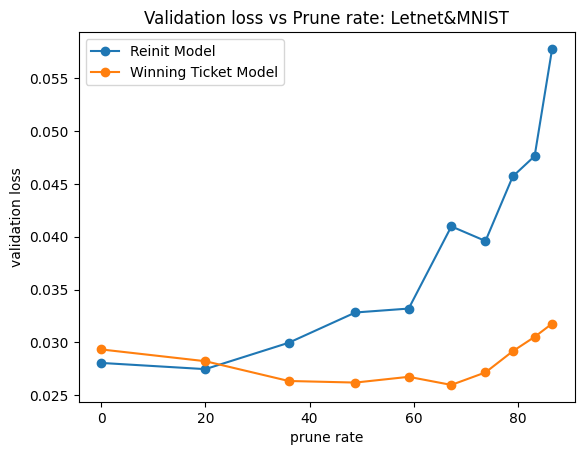

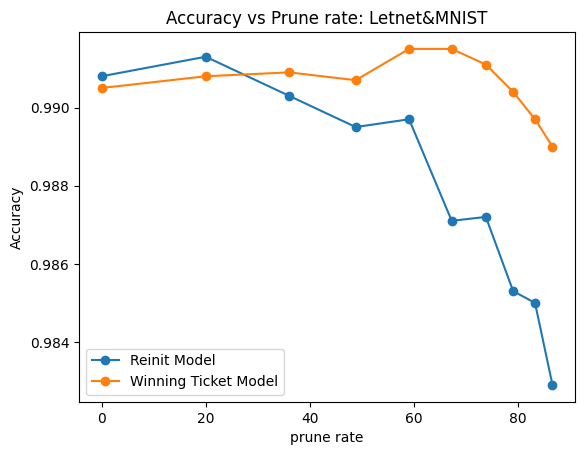

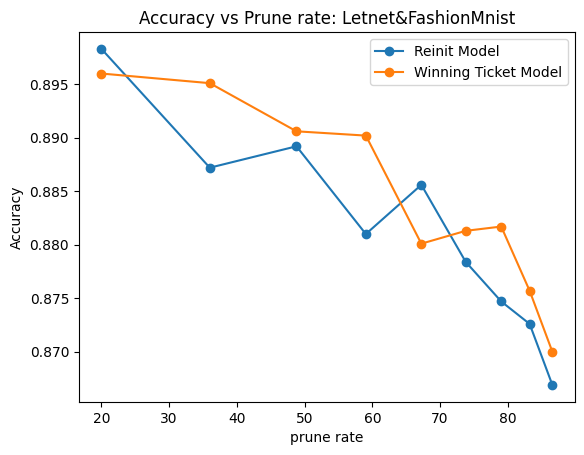

In [24]:
nonzero_param_percent = [100*0.8**i for i in range(10)]
result_reinit_true = torch.load('exp_result/data_lenet/lenet_mnist_2_100_0.001_500_reinit-True.pth')
result_reinit_false = torch.load('exp_result/data_lenet/lenet_mnist_2_100_0.001_500_reinit-False.pth')
finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/data_lenet/lenet_fashionmnist_2_100_0.001_500_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/data_lenet/lenet_fashionmnist_2_100_0.001_500_reinit-False_evaluate.pth')
finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.title.set_text('Validation loss vs Prune rate: Letnet&MNIST')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('validation loss')
ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: Letnet&MNIST')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.title.set_text('Validation loss vs Prune rate: Letnet&FashionMnist')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true_evaluate,'-o',label='Reinit Model')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false_evaluate,'-o',label='Winning Ticket Model')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('validation loss')
# ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: Letnet&FashionMnist')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

## For FC Model

In [25]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 10
n_epochs_iterative_prune = 10
num_train = 500
random_seed = 42
reinit = True
batch_size = 16
model_type = 'fc'
dataset_type = 'mnist'
dataset_type_1 = 'fashionmnist'

n_layers = 2
n_neurons = 100

lr = 1e-3
momentum = 0.9
pr = 20 # prune rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device):
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  # initialize model, optimizer, scheduler, criterion
  global model
  model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
  optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  # initialize store the model parameters
  model.apply(init_weight)
  store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'init')
  initial_state_dict = copy.deepcopy(model.state_dict())
  make_mask(model)
  # main function
  result_per_iter = {}
  nonzero_param_percent = []
  tickets_path = []
  for iter in tqdm(range(n_epochs_iterative_prune)):
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # initialize the weight after pruning
    if iter != 0:
      prune_layer_wise('percentile',pr)
      if reinit:
        model.apply(init_weight)
        reinitial_state_dict = copy.deepcopy(model.state_dict())
        init_weight_with_mask(mask,reinitial_state_dict)
      else:
        init_weight_with_mask(mask,initial_state_dict)
      # store winning ticket or reinitialized model
      store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'ticket',f'reinit-{reinit}',iter)
      tickets_path.append(store_path)
    nonzero_percent = count_nonzero_param(model)
    print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
    nonzero_param_percent.append(nonzero_percent)
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    # result store
    store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'trained',f'reinit-{reinit}',iter)
    result_per_iter[iter] = {'store_path': store_path,
                            'nonzero_percent':nonzero_percent,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/data_fc/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}')
  return tickets_path


def evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path):
  tickets_performance = {}
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  global model

  for idx,path in enumerate(tickets_path):
    model = torch.load(path)
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    # training stage
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    tickets_performance[idx] = {
                            'ticket_path': path,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/data_fc/',tickets_performance,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}','evaluate')

In [27]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tickets_path1 = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type_1,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type_1,n_layers,n_neurons,lr,pr,momentum,device,tickets_path1)


storedPath: ./model_save/fc_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.3919087364196776, accuracy:0.1092
training_loss:0.696853756904602
validation_loss:0.17807010208237917, accuracy:0.948
training_loss:0.4481976330280304
validation_loss:0.13403653156484943, accuracy:0.9577
training_loss:0.03706750273704529
validation_loss:0.11026050364711555, accuracy:0.9678
training_loss:0.26400840282440186
validation_loss:0.11357739283636038, accuracy:0.9694
training_loss:0.0011943717254325747
validation_loss:0.12119138671487763, accuracy:0.9692
training_loss:0.9121877551078796
validation_loss:0.10091259863361643, accuracy:0.9755
training_loss:0.28749892115592957
validation_loss:0.08639899263640641, accuracy:0.9767
training_loss:0.0075402338989079
validation_loss:0.08011010048540528, accuracy:0.9826
training_loss:0.00020759538165293634
validation_loss:0.0752929475321447, accuracy:0.9842
training_loss:0.0002996276889462024


 10%|█         | 1/10 [01:56<17:25, 116.19s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_0.pth
[[ 0.07606626  0.09647041 -0.02675687 ...  0.03833265  0.06067565
  -0.04525577]
 [ 0.08155838 -0.04097512  0.02462845 ...  0.03905878 -0.0017834
   0.04832786]
 [ 0.0222924  -0.03193804 -0.0881784  ...  0.07269014 -0.0198469
   0.04453918]
 ...
 [ 0.00150384  0.0362876   0.10433072 ...  0.02712188  0.06151724
   0.12054913]
 [-0.06371623 -0.01832     0.05602378 ...  0.05307211  0.08127915
   0.01564787]
 [-0.02729917 -0.00112139  0.03240958 ...  0.03056108 -0.02852318
  -0.01456792]]
[ 0.07606626  0.09647041 -0.02675687 ...  0.03056108 -0.02852318
 -0.01456792]
0.017179256677627562
[[-0.04283119 -0.01876135 -0.06377666 ... -0.07647289  0.15598518
  -0.01722742]
 [ 0.11270267  0.01546048  0.05294634 ... -0.0705025  -0.10216107
   0.11474822]
 [ 0.23171587 -0.00573694 -0.03100821 ...  0.15078045 -0.18400496
  -0.25513658]
 ...
 [-0.11213157 -0.00575971 -0.14410685 ...  0.07892932 -0.03401987
  -0.24311852]
 [-0.

 20%|██        | 2/10 [03:51<15:27, 115.91s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_1.pth
[[-0.01949381  0.01615405  0.08141911 ...  0.02763813 -0.03760101
  -0.01429467]
 [ 0.11108539  0.01906564  0.05297995 ...  0.08471227  0.
   0.01143596]
 [ 0.05493689  0.00572408  0.02520297 ...  0.00560594  0.01119711
  -0.057948  ]
 ...
 [-0.          0.08273726 -0.06976491 ...  0.02844459 -0.00882856
  -0.06744259]
 [ 0.01741223  0.0260831   0.06629497 ...  0.08014204  0.02912345
   0.        ]
 [ 0.01322029  0.          0.00093212 ...  0.02547227 -0.00190331
   0.        ]]
[-0.01949381  0.01615405  0.08141911 ...  0.00610201  0.02547227
 -0.00190331]
0.018074540048837663
[[-0.03283444 -0.         -0.1444975  ... -0.05980841  0.06418383
  -0.        ]
 [ 0.0723612  -0.         -0.09443144 ... -0.39366418 -0.15081121
   0.4577282 ]
 [-0.01711392 -0.          0.         ...  0.3140631  -0.23315133
  -0.46969587]
 ...
 [ 0.0604258  -0.          0.0076893  ...  0.04367957 -0.
   0.04885465]
 [ 0.04602813 -0.00

 30%|███       | 3/10 [05:52<13:45, 117.86s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_2.pth
[[ 0.01022915 -0.         -0.01758529 ... -0.0240132  -0.04289002
   0.        ]
 [-0.00099199 -0.03576504  0.01833696 ... -0.02606442  0.
  -0.        ]
 [ 0.02025149  0.          0.00933493 ...  0.         -0.
  -0.0016308 ]
 ...
 [ 0.          0.02456239  0.00684435 ... -0.07457992 -0.
   0.02573556]
 [-0.          0.03940649 -0.09448733 ... -0.05111752  0.06406336
   0.        ]
 [ 0.          0.          0.         ...  0.04234038  0.
  -0.        ]]
[ 0.01022915 -0.01758529  0.01115107 ...  0.18024552  0.00965414
  0.04234038]
0.018603024259209636
[[ 0.         -0.          0.04325801 ... -0.2760534  -0.01594312
   0.        ]
 [-0.13087615 -0.         -0.00553526 ...  0.07387745  0.19657707
   0.08901238]
 [ 0.         -0.          0.         ... -0.19567712 -0.22851919
  -0.03868017]
 ...
 [ 0.22299899  0.          0.         ... -0.07388396  0.
  -0.24328405]
 [-0.24607106 -0.         -0.03166819 ...  

 40%|████      | 4/10 [07:55<12:01, 120.18s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_3.pth
[[-0.         -0.         -0.         ... -0.00910176 -0.0117355
   0.        ]
 [ 0.         -0.02891799  0.         ...  0.00489021  0.
   0.        ]
 [ 0.02501983  0.         -0.         ... -0.          0.
   0.        ]
 ...
 [ 0.          0.07457364  0.         ...  0.10020479  0.
   0.04654653]
 [ 0.          0.06215926  0.03811302 ...  0.07449608 -0.03171629
   0.        ]
 [-0.         -0.         -0.         ...  0.11071652  0.
  -0.        ]]
[-0.07626475 -0.0686926  -0.04009059 ...  0.00484434  0.05431596
  0.11071652]
0.02019573822617531
[[-0.         -0.         -0.04784688 ...  0.02448503 -0.
   0.        ]
 [-0.03073717  0.         -0.         ...  0.05923214 -0.13778926
   0.05933695]
 [ 0.          0.         -0.         ... -0.02853173 -0.05064597
  -0.        ]
 ...
 [ 0.45045403  0.          0.         ... -0.07831337  0.
  -0.3332048 ]
 [-0.10712868  0.         -0.         ... -0.        

 50%|█████     | 5/10 [10:02<10:12, 122.53s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_4.pth
[[ 0.          0.         -0.         ... -0.         -0.
  -0.        ]
 [ 0.         -0.10538192 -0.         ...  0.          0.
  -0.        ]
 [ 0.00162117  0.          0.         ... -0.          0.
   0.        ]
 ...
 [-0.          0.01754355  0.         ... -0.02256973 -0.
  -0.01367359]
 [-0.         -0.02424887  0.02235628 ... -0.08723383  0.06850115
   0.        ]
 [ 0.         -0.         -0.         ...  0.1268248   0.
  -0.        ]]
[-0.0458119   0.02981775  0.00275206 ... -0.02404    -0.00205283
  0.1268248 ]
0.02171067371964455
[[ 0.          0.          0.41112608 ... -0.          0.
  -0.        ]
 [ 0.         -0.          0.         ... -0.14509894 -0.04071369
  -0.0790141 ]
 [-0.          0.         -0.         ...  0.         -0.06116059
   0.        ]
 ...
 [-0.23073198  0.         -0.         ...  0.03055529 -0.
  -0.11354594]
 [-0.05064539 -0.         -0.         ...  0.         -0.
  

 60%|██████    | 6/10 [12:10<08:16, 124.22s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_5.pth
[[ 0.          0.         -0.         ...  0.          0.
   0.        ]
 [ 0.          0.0210458   0.         ... -0.         -0.
  -0.        ]
 [ 0.         -0.         -0.         ... -0.          0.
  -0.        ]
 ...
 [ 0.         -0.          0.         ...  0.02513574  0.
  -0.        ]
 [-0.          0.02136592  0.09062967 ... -0.05013274  0.00343537
  -0.        ]
 [ 0.          0.         -0.         ...  0.08919951  0.
   0.        ]]
[-0.03992707 -0.04337526  0.01500869 ...  0.01835048  0.04990981
  0.08919951]
0.02317933179438114
[[ 0.          0.          0.15991805 ... -0.          0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.01821117  0.
  -0.2200266 ]
 [ 0.         -0.         -0.         ... -0.         -0.02098045
   0.        ]
 ...
 [-0.21666111  0.          0.         ...  0.         -0.
  -0.20326726]
 [-0.32996356  0.          0.         ...  0.         -0.
   0.     

 70%|███████   | 7/10 [14:17<06:16, 125.43s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_6.pth
[[ 0.          0.         -0.         ... -0.         -0.
   0.        ]
 [ 0.         -0.         -0.         ... -0.          0.
   0.        ]
 [ 0.          0.         -0.         ...  0.         -0.
  -0.        ]
 ...
 [-0.          0.         -0.         ...  0.07792316  0.
  -0.        ]
 [-0.         -0.         -0.01061102 ... -0.01316205 -0.
  -0.        ]
 [-0.          0.         -0.         ... -0.11328721  0.
   0.        ]]
[ 0.00157521  0.02983671 -0.07193094 ...  0.04411571 -0.07505378
 -0.11328721]
0.02521831914782524
[[-0.         -0.          0.00049843 ... -0.         -0.
   0.        ]
 [-0.          0.          0.         ...  0.          0.
   0.13306566]
 [-0.         -0.          0.         ... -0.         -0.
  -0.        ]
 ...
 [ 0.23933437  0.          0.         ... -0.         -0.
   0.10909972]
 [ 0.23641925  0.          0.         ...  0.         -0.
   0.        ]
 [-0.021003

 80%|████████  | 8/10 [16:19<04:08, 124.23s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_7.pth
[[-0.          0.         -0.         ... -0.         -0.
   0.        ]
 [-0.          0.         -0.         ... -0.          0.
  -0.        ]
 [-0.          0.          0.         ... -0.         -0.
  -0.        ]
 ...
 [-0.          0.          0.         ...  0.0954887  -0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.02446368  0.
   0.        ]]
[ 0.03415516  0.03316531 -0.0715503  ...  0.00534555  0.01859884
 -0.02446368]
0.024980103597044945
[[-0.          0.         -0.         ...  0.          0.
   0.        ]
 [ 0.         -0.         -0.         ...  0.         -0.
   0.00510102]
 [ 0.          0.          0.         ...  0.         -0.
   0.        ]
 ...
 [ 0.02684102  0.         -0.         ...  0.         -0.
  -0.17087416]
 [-0.2668661  -0.         -0.         ...  0.          0.
   0.        ]
 [ 0.     

 90%|█████████ | 9/10 [18:23<02:03, 123.98s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_8.pth
[[-0.         -0.          0.         ...  0.         -0.
   0.        ]
 [-0.         -0.         -0.         ...  0.          0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 ...
 [-0.          0.         -0.         ... -0.07097027  0.
   0.        ]
 [ 0.         -0.         -0.         ...  0.         -0.
  -0.        ]
 [-0.         -0.         -0.         ...  0.          0.
  -0.        ]]
[ 0.13771048  0.00906642 -0.01071307 ... -0.01002584  0.00552882
 -0.0078009 ]
0.027981650084257126
[[-0.         -0.         -0.         ...  0.          0.
   0.        ]
 [ 0.         -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.          0.         ...  0.         -0.
  -0.        ]
 ...
 [ 0.          0.         -0.         ...  0.         -0.
   0.1725157 ]
 [-0.36726967  0.         -0.         ...  0.         -0.
  -0.        ]
 [-0.     

100%|██████████| 10/10 [20:29<00:00, 122.92s/it]


storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_9.pth
storedPath: ./exp_result/data_fc/fc_mnist_2_100_0.001_500_reinit-True.pth
storedPath: ./model_save/fc_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:4.7693758354187015, accuracy:0.0959
training_loss:0.023310121148824692
validation_loss:0.1641636953903362, accuracy:0.9491
training_loss:0.19856184720993042
validation_loss:0.14023457663869485, accuracy:0.9566
training_loss:0.518196165561676
validation_loss:0.13998691535960534, accuracy:0.9594
training_loss:0.1358448714017868
validation_loss:0.1293720079985127, accuracy:0.9643
training_loss:0.00539133045822382
validation_loss:0.12371024183763038, accuracy:0.9666
training_loss:0.12682102620601654
validation_loss:0.10451088002915994, accuracy:0.9721
training_loss:0.021640269085764885
validation_loss:0.09476433332691185, accuracy:0.9762
training_loss:0.00017120377742685378
validation_loss:0.0841873577578234, accuracy:0.9794
training_loss:2.299840525665786e-05
validation_loss:0.079865137466817, accuracy:0.9814
training_loss:0.004609586670994759


 10%|█         | 1/10 [02:03<18:32, 123.63s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_0.pth
[[-0.00092952  0.04265213  0.02606863 ...  0.08356121 -0.05611808
  -0.04404635]
 [ 0.02994158 -0.06161087 -0.00973447 ...  0.04438468  0.0078382
   0.03487723]
 [-0.11576903  0.0015471   0.00617735 ...  0.02251143 -0.00444014
   0.01050056]
 ...
 [-0.02489091 -0.08245309  0.03375052 ...  0.09266464 -0.07207362
   0.0544231 ]
 [ 0.04050508  0.10435393  0.15309654 ...  0.03116303  0.09511945
  -0.05430854]
 [ 0.09117467  0.02949046 -0.00773141 ...  0.04342196  0.01246355
   0.11522183]]
[-0.00092952  0.04265213  0.02606863 ...  0.04342196  0.01246355
  0.11522183]
0.01714668981730938
[[-0.01672316  0.00802078 -0.2415073  ... -0.25758684  0.06749973
  -0.18586434]
 [ 0.03297687 -0.11291892  0.06220381 ...  0.05402776 -0.06406204
  -0.04193449]
 [-0.05396226 -0.0605814  -0.19421668 ... -0.00169139  0.25633475
   0.0577401 ]
 ...
 [-0.00736721  0.01898044 -0.10171024 ... -0.08614023 -0.22579852
  -0.05055336]
 [-0

 20%|██        | 2/10 [04:08<16:34, 124.29s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_1.pth
[[-0.          0.02009154  0.00350798 ...  0.06100003 -0.07867758
  -0.06660597]
 [ 0.02349882 -0.06805295 -0.         ...  0.03794202  0.
   0.02843418]
 [-0.11832912  0.          0.         ...  0.01995147 -0.
   0.        ]
 ...
 [-0.02938901 -0.0869513   0.0292521  ...  0.08816643 -0.07657184
   0.04992496]
 [ 0.04759102  0.11143976  0.16018467 ...  0.03824902  0.10220528
  -0.04722248]
 [ 0.08919892  0.02751454 -0.         ...  0.04144561 -0.
   0.11324608]]
[ 0.02009154  0.00350798 -0.06559152 ...  0.03488956  0.04144561
  0.11324608]
0.025778294727206236
[[ 0.0000000e+00 -0.0000000e+00 -1.6004021e-01 ... -1.4188053e-01
   5.2324645e-02 -1.1225491e-01]
 [ 0.0000000e+00  1.7028635e-02  1.1961000e-01 ...  7.3262915e-02
  -6.7532368e-02  5.0313585e-02]
 [-4.2393237e-02 -4.2683464e-01 -2.0891489e-01 ... -0.0000000e+00
   2.8745079e-01  8.5682712e-02]
 ...
 [-0.0000000e+00 -0.0000000e+00  1.1050676e-01 ... -4

 30%|███       | 3/10 [06:15<14:39, 125.64s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_2.pth
[[-0.          0.         -0.         ...  0.04772115 -0.09195745
  -0.07988576]
 [ 0.         -0.06764555 -0.         ...  0.03835051  0.
   0.0288428 ]
 [-0.11902766  0.          0.         ...  0.         -0.
   0.        ]
 ...
 [-0.03005028 -0.08761046  0.02859122 ...  0.08750727 -0.077231
   0.04926372]
 [ 0.02992671  0.09377579  0.14251792 ...  0.02058461  0.0845413
  -0.06488661]
 [ 0.10999045  0.04830509 -0.         ...  0.06223668 -0.
   0.1340374 ]]
[-0.07887113  0.04533709 -0.09493098 ...  0.05568039  0.06223668
  0.1340374 ]
0.033651359379291534
[[ 0.         -0.         -0.11103934 ... -0.14371206 -0.02532633
  -0.13187751]
 [ 0.          0.          0.03931417 ...  0.15918833  0.06680774
  -0.0425818 ]
 [-0.         -0.4153535  -0.329189   ... -0.          0.24777588
   0.15664268]
 ...
 [-0.         -0.         -0.00526235 ... -0.          0.
  -0.23758654]
 [-0.         -0.08216252 -0.05750673

 40%|████      | 4/10 [08:19<12:30, 125.10s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_3.pth
[[-0.          0.         -0.         ...  0.05474176 -0.08493602
  -0.07286432]
 [ 0.         -0.06977522 -0.         ...  0.03622032  0.
   0.        ]
 [-0.11182344  0.          0.         ...  0.         -0.
   0.        ]
 ...
 [-0.         -0.07708289  0.         ...  0.09803484 -0.06670333
   0.05979217]
 [ 0.          0.10369182  0.15243292 ...  0.          0.09445733
  -0.0549712 ]
 [ 0.08282906  0.02114411 -0.         ...  0.03507567 -0.
   0.10687622]]
[-0.0718497   0.0523577  -0.08790955 ...  0.02851954  0.03507567
  0.10687622]
0.04217752069234848
[[ 0.         -0.         -0.15729448 ... -0.07884657 -0.
  -0.11081829]
 [ 0.          0.          0.         ...  0.1380155   0.1020362
   0.        ]
 [-0.         -0.17526421 -0.24335365 ... -0.          0.38581592
   0.02414463]
 ...
 [-0.         -0.         -0.         ... -0.          0.
  -0.2356689 ]
 [-0.         -0.04496732 -0.         ...  0

 50%|█████     | 5/10 [10:24<10:24, 124.88s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_4.pth
[[-0.          0.         -0.         ...  0.05302721 -0.08665025
  -0.07457856]
 [ 0.         -0.06207905 -0.         ...  0.          0.
   0.        ]
 [-0.11977535  0.          0.         ...  0.         -0.
   0.        ]
 ...
 [-0.         -0.08952376  0.         ...  0.08559398 -0.07914429
   0.04735114]
 [ 0.          0.09980284  0.14854555 ...  0.          0.09056835
  -0.05885947]
 [ 0.09624009  0.         -0.         ...  0.         -0.
   0.12028719]]
[-0.07356393  0.05064315 -0.08962379 ... -0.05285245  0.10126332
  0.12028719]
0.04993492439389229
[[ 0.         -0.         -0.14877917 ... -0.12905619 -0.
  -0.08121031]
 [ 0.          0.          0.         ...  0.1890566  -0.02308977
   0.        ]
 [-0.         -0.28092122 -0.2570506  ... -0.          0.401717
   0.        ]
 ...
 [-0.         -0.         -0.         ... -0.          0.
  -0.10532833]
 [-0.         -0.         -0.         ...  0.

 60%|██████    | 6/10 [12:29<08:19, 124.90s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_5.pth
[[-0.          0.         -0.         ...  0.04791121 -0.09176598
  -0.07969429]
 [ 0.         -0.0746116  -0.         ...  0.          0.
   0.        ]
 [-0.1165899   0.          0.         ...  0.         -0.
   0.        ]
 ...
 [-0.         -0.0825725   0.         ...  0.09254523 -0.07219304
   0.        ]
 [ 0.          0.10860439  0.15734422 ...  0.          0.09936991
  -0.05005877]
 [ 0.09076588  0.         -0.         ...  0.         -0.
   0.11481304]]
[-0.07867967  0.04552715 -0.09473952 ... -0.05723549  0.09513708
  0.11481304]
0.05835347697138786
[[ 0.         -0.         -0.1868707  ... -0.04011618 -0.
  -0.        ]
 [ 0.          0.          0.         ...  0.15398525 -0.
   0.        ]
 [-0.         -0.18432997 -0.31723997 ... -0.          0.42427024
   0.        ]
 ...
 [-0.         -0.         -0.         ... -0.          0.
  -0.0928509 ]
 [-0.         -0.         -0.         ...  0.      

 70%|███████   | 7/10 [14:33<06:14, 124.71s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_6.pth
[[-0.          0.         -0.         ...  0.         -0.07728678
  -0.06521511]
 [ 0.         -0.07193569 -0.         ...  0.          0.
   0.        ]
 [-0.11926714  0.          0.         ...  0.         -0.
   0.        ]
 ...
 [-0.         -0.08860843  0.         ...  0.0865093  -0.07822897
   0.        ]
 [ 0.          0.09381032  0.14255244 ...  0.          0.08457583
  -0.        ]
 [ 0.10029458  0.         -0.         ...  0.         -0.
   0.12434199]]
[-0.0642005  -0.08026031 -0.07619123 ...  0.07779247  0.102501
  0.12434199]
0.06593339592218399
[[ 0.         -0.         -0.14906636 ... -0.         -0.
  -0.        ]
 [ 0.          0.          0.         ...  0.14846748 -0.
   0.        ]
 [-0.         -0.18396981 -0.24986905 ... -0.          0.36238787
   0.        ]
 ...
 [-0.         -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.         -0.         ...  0.        

 80%|████████  | 8/10 [16:36<04:08, 124.28s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_7.pth
[[-0.          0.         -0.         ...  0.         -0.09481607
  -0.        ]
 [ 0.         -0.07443645 -0.         ...  0.          0.
   0.        ]
 [-0.12010842  0.          0.         ...  0.         -0.
   0.        ]
 ...
 [-0.         -0.09136467  0.         ...  0.08375306 -0.0809852
   0.        ]
 [ 0.          0.09895901  0.14770126 ...  0.          0.08972453
  -0.        ]
 [ 0.0909389   0.         -0.         ...  0.         -0.
   0.11498606]]
[-0.0977896  -0.09372052  0.07272456 ...  0.06844802  0.09592032
  0.11498606]
0.07435475289821625
[[ 0.         -0.         -0.14346267 ... -0.         -0.
  -0.        ]
 [ 0.          0.          0.         ...  0.10819282 -0.
   0.        ]
 [-0.         -0.2733849  -0.22112931 ... -0.          0.35531226
   0.        ]
 ...
 [-0.         -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.         -0.         ...  0.       

 90%|█████████ | 9/10 [18:43<02:05, 125.03s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_8.pth
[[-0.          0.         -0.         ...  0.         -0.079842
  -0.        ]
 [ 0.         -0.0717821  -0.         ...  0.          0.
   0.        ]
 [-0.12601234  0.          0.         ...  0.         -0.
   0.        ]
 ...
 [-0.         -0.08878664  0.         ...  0.08633109 -0.07840718
   0.        ]
 [ 0.          0.09577311  0.14451386 ...  0.          0.08653862
  -0.        ]
 [ 0.10303405  0.         -0.         ...  0.         -0.
   0.12708126]]
[-0.08281554 -0.07874645  0.13083056 ...  0.10026089  0.1079969
  0.12708126]
0.08213981986045837
[[ 0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [ 0.          0.          0.         ...  0.         -0.
   0.        ]
 [-0.         -0.1034054  -0.23372431 ... -0.          0.37971672
   0.        ]
 ...
 [-0.         -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.         -0.         ...  0.         

100%|██████████| 10/10 [20:52<00:00, 125.20s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_9.pth
storedPath: ./exp_result/data_fc/fc_mnist_2_100_0.001_500_reinit-False.pth


validation_loss:2.988509803009033, accuracy:0.0998
training_loss:0.3539026379585266
validation_loss:0.4504382460772991, accuracy:0.8384
training_loss:0.6523699164390564
validation_loss:0.40923168253898623, accuracy:0.8514
training_loss:0.4013912081718445
validation_loss:0.4383847502171993, accuracy:0.8391
training_loss:0.4833782911300659
validation_loss:0.4261596122801304, accuracy:0.8503
training_loss:0.8391768932342529
validation_loss:0.4043992332644761, accuracy:0.8612
training_loss:0.39734333753585815
validation_loss:0.37157240206599235, accuracy:0.8696
training_loss:0.4513375163078308
validation_loss:0.3624083359181881, accuracy:0.8729
training_loss:0.08036099374294281
validation_loss:0.3311103418380022, accuracy:0.8814
training_loss:0.49245786666870117
validation_loss:0.3235193864420056, accuracy:0.8871
training_loss:0.08932031691074371
validation_loss:2.804488028717041, accuracy:0.0809
training_loss:0.5364916920661926
validation_loss:0.46527857581973076, accuracy:0.8303
training

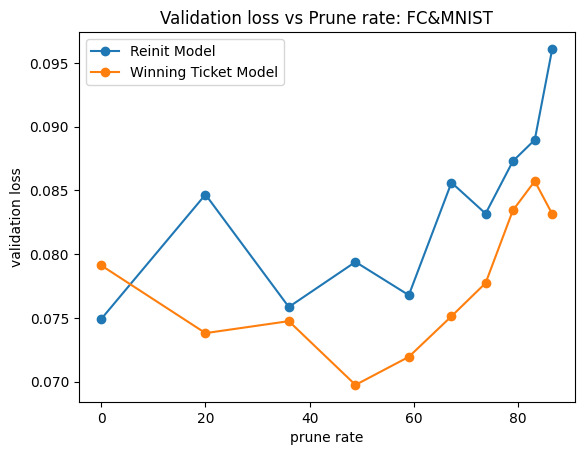

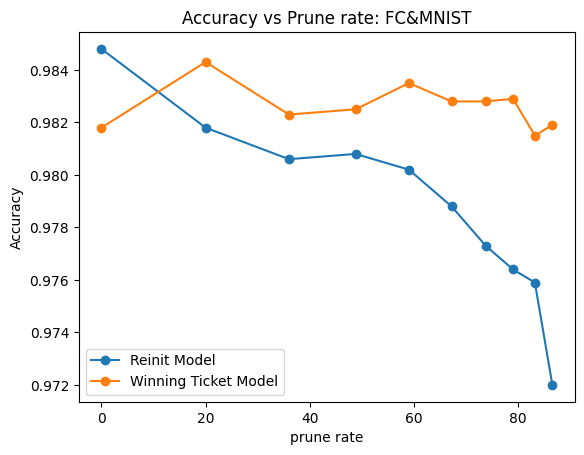

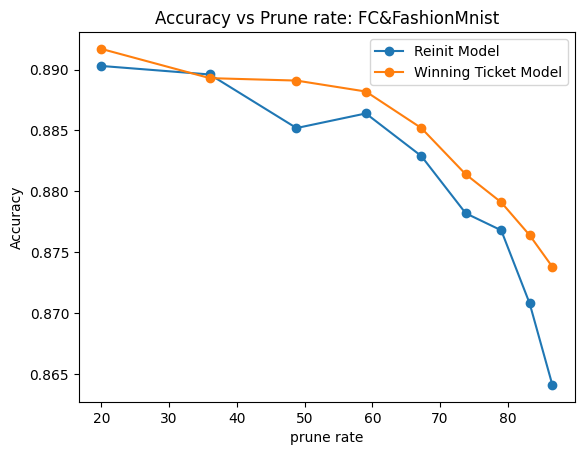

In [28]:
nonzero_param_percent = [100*0.8**i for i in range(10)]
result_reinit_true = torch.load('exp_result/data_fc/fc_mnist_2_100_0.001_500_reinit-True.pth')
result_reinit_false = torch.load('exp_result/data_fc/fc_mnist_2_100_0.001_500_reinit-False.pth')
finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/data_fc/fc_fashionmnist_2_100_0.001_500_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/data_fc/fc_fashionmnist_2_100_0.001_500_reinit-False_evaluate.pth')
finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.title.set_text('Validation loss vs Prune rate: FC&MNIST')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('validation loss')
ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: FC&MNIST')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.title.set_text('Validation loss vs Prune rate: FC&FashionMnist')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true_evaluate,'-o',label='Reinit Model')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false_evaluate,'-o',label='Winning Ticket Model')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('validation loss')
# ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: FC&FashionMnist')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# Experiment analysis: Optimizer Difference


## For FC model

In [29]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 10
n_epochs_iterative_prune = 10
num_train = 500
random_seed = 42
reinit = True
batch_size = 16
model_type = 'fc'
dataset_type = 'mnist'

n_layers = 2
n_neurons = 100

lr = 1e-3
momentum = 0.9
pr = 20 # prune rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
def expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device):
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  # initialize model, optimizer, scheduler, criterion
  global model
  model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  # initialize store the model parameters
  model.apply(init_weight)
  store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'init')
  initial_state_dict = copy.deepcopy(model.state_dict())
  make_mask(model)
  # main function
  result_per_iter = {}
  nonzero_param_percent = []
  tickets_path = []
  for iter in tqdm(range(n_epochs_iterative_prune)):
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # initialize the weight after pruning
    if iter != 0:
      prune_layer_wise('percentile',pr)
      if reinit:
        model.apply(init_weight)
        reinitial_state_dict = copy.deepcopy(model.state_dict())
        init_weight_with_mask(mask,reinitial_state_dict)
      else:
        init_weight_with_mask(mask,initial_state_dict)
      # store winning ticket or reinitialized model
      store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'ticket',f'reinit-{reinit}',iter)
      tickets_path.append(store_path)
    nonzero_percent = count_nonzero_param(model)
    print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
    nonzero_param_percent.append(nonzero_percent)
    # train the model for each iteration
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    # result store
    store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'trained',f'reinit-{reinit}',iter)
    result_per_iter[iter] = {'store_path': store_path,
                            'nonzero_percent':nonzero_percent,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/optim_fc/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}')
  return tickets_path


def evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path):
  tickets_performance = {}
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  global model
  for idx,path in enumerate(tickets_path):
    model = torch.load(path)
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    # training stage
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    tickets_performance[idx] = {
                            'ticket_path': path,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/optim_fc/',tickets_performance,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}','evaluate')

In [31]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tickets_path1 = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path1)

storedPath: ./model_save/fc_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.285047161102295, accuracy:0.123
training_loss:0.501677930355072
validation_loss:0.19267904946506023, accuracy:0.9435
training_loss:0.08531884849071503
validation_loss:0.14479917897749692, accuracy:0.9539
training_loss:0.001321249408647418
validation_loss:0.12111809625509196, accuracy:0.9615
training_loss:0.16274115443229675
validation_loss:0.09246887566079386, accuracy:0.9718
training_loss:0.08573990315198898
validation_loss:0.09386665480202501, accuracy:0.9729
training_loss:0.003903997130692005
validation_loss:0.09777928003479028, accuracy:0.9719
training_loss:0.006871302146464586
validation_loss:0.07608754208746123, accuracy:0.9795
training_loss:3.014143840118777e-05
validation_loss:0.07531309105474485, accuracy:0.9804
training_loss:0.0006662718951702118
validation_loss:0.07291756513291617, accuracy:0.982
training_loss:2.4636276066303253e-05


 10%|█         | 1/10 [02:18<20:42, 138.04s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_0.pth
[[ 0.02285056  0.05559344 -0.01659699 ...  0.11020608 -0.02757346
   0.00974767]
 [ 0.04569733  0.00416644  0.01587799 ... -0.00316869  0.01976852
   0.06429665]
 [-0.00935053 -0.07367211 -0.03504692 ...  0.03710697 -0.06383105
  -0.00494959]
 ...
 [ 0.02125474  0.03709149  0.0176543  ...  0.02275254  0.0017487
   0.03347063]
 [ 0.01747552  0.01003019 -0.0423494  ... -0.08522562 -0.0220394
  -0.01489245]
 [ 0.13658635  0.0273859   0.02558445 ...  0.08583989  0.04325437
   0.08699736]]
[ 0.02285056  0.05559344 -0.01659699 ...  0.08583989  0.04325437
  0.08699736]
0.020712819322943686
[[ 0.02467735  0.04117282  0.16810058 ... -0.00701518 -0.06234167
  -0.04445822]
 [-0.1929965  -0.23681514 -0.0690269  ... -0.0609778  -0.01669941
   0.08695978]
 [-0.0684395   0.04544762  0.06494342 ...  0.03492563 -0.1275674
  -0.1059518 ]
 ...
 [-0.0330766   0.26940462 -0.2129736  ...  0.12259609 -0.15864228
  -0.15485989]
 [ 0.1

 20%|██        | 2/10 [04:36<18:24, 138.08s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_1.pth
[[ 0.02821752 -0.00867908 -0.         ...  0.11463445 -0.01779484
   0.        ]
 [-0.08631594  0.          0.         ... -0.         -0.
   0.08328553]
 [-0.          0.03414038 -0.09671704 ...  0.00081417  0.04034558
  -0.        ]
 ...
 [-0.03845036 -0.13783899  0.         ...  0.01868046 -0.
  -0.06084167]
 [ 0.          0.          0.00913548 ...  0.07992241  0.03876895
   0.        ]
 [-0.03957665 -0.02448551 -0.04116999 ...  0.02080844  0.07980647
   0.00099384]]
[ 0.02821752 -0.00867908  0.04748182 ...  0.02080844  0.07980647
  0.00099384]
0.02179776020348072
[[-0.         -0.00927954 -0.21064308 ... -0.         -0.02202846
  -0.06549626]
 [-0.15108375  0.13451532 -0.09634944 ... -0.00664866 -0.
   0.07750785]
 [-0.09800065 -0.09203148 -0.04641743 ...  0.          0.13042869
   0.06767643]
 ...
 [ 0.          0.4117612   0.08971591 ... -0.22977911  0.05529943
  -0.14088923]
 [ 0.2738606  -0.01482831 -0

 30%|███       | 3/10 [06:53<16:04, 137.85s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_2.pth
[[-0.06818844  0.          0.         ...  0.0076209   0.
   0.        ]
 [ 0.03514453 -0.          0.         ... -0.         -0.
   0.07659385]
 [-0.         -0.06579712 -0.04287063 ... -0.         -0.07297294
  -0.        ]
 ...
 [-0.01355528  0.08676714 -0.         ... -0.          0.
   0.00304285]
 [-0.         -0.         -0.         ... -0.01219736 -0.01708929
   0.        ]
 [-0.01794156 -0.06779497 -0.05126186 ...  0.         -0.07522589
  -0.        ]]
[-0.06818844 -0.06916475  0.02541902 ... -0.05493062 -0.05889503
 -0.07522589]
0.0230586975812912
[[ 0.          0.         -0.00924468 ...  0.         -0.
   0.14214198]
 [ 0.11315211 -0.67477375 -0.10497721 ...  0.          0.
  -0.20120901]
 [ 0.32579717  0.16956604 -0.17826967 ... -0.          0.12691544
   0.06277702]
 ...
 [-0.          0.07690629  0.20953016 ...  0.15127987 -0.05189725
  -0.28700104]
 [ 0.00485473 -0.          0.01938839 ...  0.

 40%|████      | 4/10 [09:11<13:47, 137.84s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_3.pth
[[ 0.03490828 -0.          0.         ... -0.         -0.
  -0.        ]
 [-0.09472667  0.          0.         ... -0.          0.
   0.05369747]
 [ 0.          0.0515219   0.05745896 ... -0.          0.01056689
  -0.        ]
 ...
 [ 0.          0.01263566  0.         ...  0.          0.
   0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
   0.        ]
 [ 0.          0.04763411  0.09533316 ...  0.          0.07360642
  -0.        ]]
[ 0.03490828 -0.0187095  -0.0258582  ... -0.01970515 -0.05886291
  0.07360642]
0.02453879453241825
[[ 0.         -0.          0.         ... -0.          0.
   0.08032541]
 [ 0.04103477 -0.14464469  0.24229546 ... -0.          0.
  -0.01860414]
 [-0.15055268  0.02804735  0.00380958 ... -0.          0.10102385
   0.3907321 ]
 ...
 [-0.         -0.05611245 -0.0325806  ...  0.09981184  0.00722877
  -0.12065274]
 [-0.         -0.          0.         ... -0.       

 50%|█████     | 5/10 [11:28<11:28, 137.66s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_4.pth
[[ 0.02254645 -0.          0.         ...  0.         -0.
   0.        ]
 [ 0.02479334 -0.         -0.         ...  0.         -0.
  -0.01673805]
 [ 0.          0.01691606  0.00143356 ... -0.         -0.
  -0.        ]
 ...
 [-0.          0.         -0.         ... -0.         -0.
   0.        ]
 [-0.         -0.          0.         ...  0.          0.
  -0.        ]
 [ 0.         -0.01355311  0.07025219 ...  0.          0.01389998
   0.        ]]
[ 0.02254645  0.02119062 -0.05399422 ...  0.02168856  0.11722396
  0.01389998]
0.026437167078256607
[[-0.          0.         -0.         ... -0.          0.
   0.2182638 ]
 [ 0.          0.15746456 -0.28671482 ... -0.         -0.
  -0.        ]
 [ 0.16368806 -0.         -0.         ... -0.          0.26017287
   0.04961829]
 ...
 [ 0.         -0.10021018 -0.         ... -0.12049376 -0.
  -0.02020423]
 [ 0.         -0.          0.         ...  0.         -0.0033311
  

 60%|██████    | 6/10 [13:46<09:10, 137.55s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_5.pth
[[-0.          0.         -0.         ...  0.          0.
   0.        ]
 [ 0.         -0.         -0.         ...  0.         -0.
  -0.        ]
 [-0.          0.         -0.         ... -0.          0.
  -0.        ]
 ...
 [ 0.         -0.         -0.         ...  0.         -0.
  -0.        ]
 [ 0.          0.         -0.         ... -0.          0.
   0.        ]
 [-0.         -0.          0.06938356 ...  0.         -0.
  -0.        ]]
[ 0.01741127 -0.03863266 -0.1456542  ...  0.00964892  0.04910471
  0.01938669]
0.027863602340221408
[[ 0.          0.          0.         ...  0.          0.
   0.0953932 ]
 [ 0.          0.07402426 -0.05206974 ...  0.          0.
  -0.        ]
 [-0.49311563  0.         -0.         ... -0.         -0.06677094
   0.08366951]
 ...
 [-0.          0.18950744 -0.         ...  0.1178403  -0.
   0.        ]
 [ 0.          0.          0.         ... -0.          0.
   0.        ]
 [

 70%|███████   | 7/10 [15:59<06:48, 136.10s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_6.pth
[[-0.          0.          0.         ...  0.         -0.
  -0.        ]
 [ 0.         -0.          0.         ...  0.         -0.
   0.        ]
 [-0.          0.         -0.         ... -0.          0.
  -0.        ]
 ...
 [ 0.         -0.         -0.         ...  0.          0.
   0.        ]
 [ 0.         -0.          0.         ...  0.         -0.
  -0.        ]
 [-0.         -0.         -0.05566644 ... -0.          0.
   0.        ]]
[ 0.03126308 -0.06695167  0.01868647 ... -0.19261171 -0.18997975
 -0.09288999]
0.03299664556980133
[[-0.         -0.          0.         ...  0.         -0.
   0.02072811]
 [ 0.          0.12706842 -0.0135447  ...  0.          0.
   0.        ]
 [-0.08585997  0.         -0.         ...  0.         -0.07335114
  -0.07162335]
 ...
 [ 0.         -0.19134702 -0.         ... -0.18143073  0.
   0.        ]
 [ 0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [ 

 80%|████████  | 8/10 [18:03<04:24, 132.37s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_7.pth
[[ 0.          0.          0.         ... -0.          0.
  -0.        ]
 [ 0.         -0.         -0.         ... -0.         -0.
   0.        ]
 [ 0.         -0.         -0.         ... -0.          0.
  -0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
  -0.        ]
 [-0.         -0.          0.         ... -0.         -0.
  -0.        ]
 [-0.         -0.          0.04221637 ...  0.          0.
  -0.        ]]
[-0.00585788 -0.06403166 -0.10628255 ... -0.12345219 -0.02110838
  0.04989307]
0.032827939838171005
[[-0.          0.         -0.         ...  0.         -0.
  -0.        ]
 [ 0.         -0.00790194  0.         ...  0.          0.
  -0.        ]
 [-0.2664821   0.          0.         ...  0.          0.19123644
  -0.30570176]
 ...
 [-0.         -0.13344686  0.         ...  0.06785899 -0.
  -0.        ]
 [-0.          0.         -0.         ...  0.          0.
   0.        ]
 [

 90%|█████████ | 9/10 [20:12<02:11, 131.25s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_8.pth
[[ 0.          0.         -0.         ...  0.         -0.
   0.        ]
 [ 0.         -0.         -0.         ...  0.          0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.          0.
  -0.        ]
 ...
 [ 0.         -0.          0.         ...  0.         -0.
   0.        ]
 [ 0.         -0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.12932202 ... -0.          0.
   0.        ]]
[ 0.16185972  0.2248581   0.32900953 ... -0.20949206 -0.09726936
 -0.11693122]
0.035934428125619894
[[ 0.         -0.         -0.         ...  0.          0.
  -0.        ]
 [-0.          0.          0.         ...  0.         -0.
  -0.        ]
 [ 0.3375028  -0.          0.         ...  0.         -0.09661192
  -0.10872143]
 ...
 [ 0.         -0.16140257  0.         ...  0.06166031 -0.
   0.        ]
 [-0.          0.         -0.         ...  0.         -0.
   0.        ]
 [

100%|██████████| 10/10 [22:17<00:00, 133.71s/it]


storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-True_9.pth
storedPath: ./exp_result/optim_fc/fc_mnist_2_100_0.001_500_reinit-True.pth
storedPath: ./model_save/fc_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.6078527027130125, accuracy:0.0957
training_loss:0.5406616926193237
validation_loss:0.1993632874984294, accuracy:0.9399
training_loss:0.3893498182296753
validation_loss:0.14666932891719042, accuracy:0.954
training_loss:0.4639098644256592
validation_loss:0.10794680139776319, accuracy:0.9676
training_loss:0.003927648067474365
validation_loss:0.0943247274167661, accuracy:0.9724
training_loss:0.0009826209861785173
validation_loss:0.10578433530222973, accuracy:0.9698
training_loss:0.3209226131439209
validation_loss:0.08817263181374947, accuracy:0.9754
training_loss:0.0269341841340065
validation_loss:0.07597209910161419, accuracy:0.98
training_loss:0.0004851882695220411
validation_loss:0.07332154647886972, accuracy:0.9817
training_loss:0.0011995628010481596
validation_loss:0.07173281067904008, accuracy:0.9832
training_loss:2.6910207452601753e-05


 10%|█         | 1/10 [02:03<18:32, 123.64s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_0.pth
[[-0.00018425  0.03220695  0.0398997  ...  0.02973199  0.05212749
   0.0009035 ]
 [ 0.00075005  0.02054844  0.00995387 ... -0.03612063  0.00241479
  -0.01844615]
 [ 0.049748    0.06853109  0.01286    ...  0.10506961 -0.00898525
  -0.0074718 ]
 ...
 [ 0.08938789 -0.02514811 -0.02949255 ...  0.00837897  0.09328476
   0.04109081]
 [ 0.01085561  0.05392621  0.07498079 ...  0.10462382  0.0375859
   0.0643226 ]
 [ 0.06353893 -0.07055615  0.14995411 ...  0.10605627  0.09086864
   0.04151024]]
[-0.00018425  0.03220695  0.0398997  ...  0.10605627  0.09086864
  0.04151024]
0.021039919555187227
[[-0.133628   -0.04630632  0.20376171 ... -0.05169364  0.18562293
   0.08047259]
 [-0.07189085 -0.15447214 -0.18880424 ...  0.07724258  0.05938211
   0.04056941]
 [ 0.11052892 -0.09063898  0.32769695 ...  0.31400585 -0.01185785
   0.11694189]
 ...
 [ 0.11150113  0.03672984  0.08168099 ...  0.07251466 -0.17077458
   0.26745513]
 [ 

 20%|██        | 2/10 [04:18<17:20, 130.09s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_1.pth
[[-0.          0.00497717  0.01266987 ...  0.00250211  0.024898
  -0.        ]
 [ 0.          0.          0.         ... -0.04136661  0.
  -0.        ]
 [ 0.04798487  0.06676913 -0.         ...  0.10330774 -0.
  -0.        ]
 ...
 [ 0.04037253 -0.07416278 -0.0785073  ... -0.          0.0442689
  -0.00792415]
 [-0.          0.04628486  0.06733987 ...  0.09698321  0.02994455
   0.05668144]
 [ 0.06042298 -0.07367169  0.1468379  ...  0.1029407   0.08775329
   0.03839455]]
[0.00497717 0.01266987 0.02076987 ... 0.1029407  0.08775329 0.03839455]
0.028395169973373414
[[-0.03913617 -0.05356051  0.19264849 ... -0.11371674  0.01306372
   0.07569513]
 [ 0.04095091 -0.12476169 -0.25302118 ...  0.03702827  0.0839844
   0.00803832]
 [ 0.08639478 -0.05896226  0.28868356 ...  0.13158426  0.
   0.20816413]
 ...
 [-0.03842582  0.01376643  0.20646109 ... -0.06126292 -0.08792302
   0.26688263]
 [ 0.         -0.12425565 -0.2429899 

 30%|███       | 3/10 [06:24<14:57, 128.28s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_2.pth
[[-0.          0.          0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.03132481  0.
  -0.        ]
 [ 0.02759461  0.04637808 -0.         ...  0.08291779 -0.
  -0.        ]
 ...
 [ 0.03944487 -0.07509111 -0.07943565 ... -0.          0.04334125
   0.        ]
 [-0.          0.04880854  0.06986293 ...  0.0995059   0.03246831
   0.05920463]
 [ 0.05477396 -0.07932042  0.14118803 ...  0.09729204  0.082105
   0.03274548]]
[-0.06123065  0.05194675 -0.05442771 ...  0.09729204  0.082105
  0.03274548]
0.036236654967069626
[[-0.         -0.01139149  0.2514442  ... -0.15935619  0.
   0.02803057]
 [ 0.         -0.24915992 -0.18361895 ... -0.          0.13647331
   0.        ]
 [ 0.16212143  0.02784726  0.19765566 ...  0.16418435  0.
   0.1735267 ]
 ...
 [-0.         -0.          0.18956913 ...  0.01711964 -0.11367188
   0.3306892 ]
 [ 0.         -0.13801722 -0.23352003 ... -0. 

 40%|████      | 4/10 [08:30<12:45, 127.51s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_3.pth
[[-0.          0.          0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.          0.
  -0.        ]
 [ 0.          0.03973746 -0.         ...  0.07627659 -0.
  -0.        ]
 ...
 [ 0.07753976 -0.03699601 -0.04134073 ... -0.          0.08143609
   0.        ]
 [-0.          0.04106631  0.06212071 ...  0.09176346  0.
   0.05146268]
 [ 0.05115502 -0.08293894  0.13756953 ...  0.09367323  0.07848579
  -0.        ]]
[-0.06338096  0.04979568 -0.05657837 ...  0.13303554  0.09367323
  0.07848579]
0.04510511830449104
[[-0.         -0.          0.15164673 ... -0.3707541   0.
   0.        ]
 [ 0.         -0.28752816 -0.16977392 ... -0.          0.09482561
   0.        ]
 [ 0.16886595 -0.          0.22252314 ...  0.19026256  0.
   0.13196212]
 ...
 [-0.         -0.          0.13726792 ... -0.         -0.03194527
   0.34401193]
 [ 0.         -0.17732605 -0.2923802  ... -0.      

 50%|█████     | 5/10 [10:41<10:44, 128.83s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_4.pth
[[-0.          0.          0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.          0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.0921386  -0.
  -0.        ]
 ...
 [ 0.02711469 -0.         -0.         ... -0.          0.0310112
   0.        ]
 [-0.          0.          0.07333089 ...  0.10297436  0.
   0.0626726 ]
 [ 0.04447394 -0.08962132  0.13088706 ...  0.08699121  0.07180354
  -0.        ]]
[-0.05546503  0.05771203 -0.04866209 ...  0.126353    0.08699121
  0.07180354]
0.05414347499608994
[[-0.         -0.          0.2165081  ... -0.21071538  0.
   0.        ]
 [ 0.         -0.3680669  -0.17925784 ... -0.          0.0543975
   0.        ]
 [ 0.13843377 -0.          0.32488564 ...  0.2331693   0.
   0.21554042]
 ...
 [-0.         -0.          0.19013053 ... -0.         -0.
   0.30012837]
 [ 0.         -0.18540198 -0.2536356  ... -0.          0.1586

 60%|██████    | 6/10 [12:48<08:32, 128.02s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_5.pth
[[-0.          0.          0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.          0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.0851176  -0.
  -0.        ]
 ...
 [ 0.         -0.         -0.         ... -0.          0.
   0.        ]
 [-0.          0.          0.06070431 ...  0.09034821  0.
   0.05004583]
 [ 0.         -0.08748761  0.133023   ...  0.08912522  0.07393777
  -0.        ]]
[-0.0782605   0.03491678  0.03548135 ...  0.12848863  0.08912522
  0.07393777]
0.06233255639672279
[[-0.         -0.          0.16287105 ... -0.17308885  0.
   0.        ]
 [ 0.         -0.49435282 -0.21857361 ... -0.         -0.
   0.        ]
 [ 0.20374341 -0.          0.28511265 ...  0.3043981   0.
   0.19478388]
 ...
 [-0.         -0.          0.20801832 ... -0.         -0.
   0.41654143]
 [ 0.         -0.09423151 -0.3309578  ... -0.          0.12130305
   0.    

 70%|███████   | 7/10 [14:56<06:24, 128.08s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_6.pth
[[-0.          0.          0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.          0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.07764536 -0.
  -0.        ]
 ...
 [ 0.         -0.         -0.         ... -0.          0.
   0.        ]
 [-0.          0.          0.         ...  0.12238805  0.
   0.        ]
 [ 0.         -0.09004285  0.13046697 ...  0.08656982  0.0713824
  -0.        ]]
[-0.06384762 -0.06294297 -0.1087763  ...  0.12593296  0.08656982
  0.0713824 ]
0.07139358520507813
[[-0.         -0.          0.22945301 ... -0.22097223  0.
   0.        ]
 [ 0.         -0.5627723  -0.20204093 ... -0.         -0.
   0.        ]
 [ 0.14709222 -0.          0.33635727 ...  0.23673095  0.
   0.22443943]
 ...
 [-0.         -0.          0.275853   ... -0.         -0.
   0.4530102 ]
 [ 0.         -0.         -0.27635238 ... -0.         -0.
   0.        ]
 [ 

 80%|████████  | 8/10 [17:04<04:15, 127.91s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_7.pth
[[-0.          0.          0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.          0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.09566351 -0.
  -0.        ]
 ...
 [ 0.         -0.         -0.         ... -0.          0.
   0.        ]
 [-0.          0.          0.         ...  0.09130616  0.
   0.        ]
 [ 0.         -0.06192223  0.15858641 ...  0.11469047  0.
  -0.        ]]
[-0.09340346 -0.08321037 -0.07279304 ...  0.10474212  0.1540525
  0.11469047]
0.07977894693613052
[[-0.         -0.          0.22306134 ... -0.3090192   0.
   0.        ]
 [ 0.         -0.5445377  -0.23694423 ... -0.         -0.
   0.        ]
 [ 0.         -0.          0.2732814  ...  0.32009202  0.
   0.20429745]
 ...
 [-0.         -0.          0.29039228 ... -0.         -0.
   0.5549787 ]
 [ 0.         -0.         -0.35782254 ... -0.         -0.
   0.        ]
 [ 0.      

 90%|█████████ | 9/10 [19:08<02:06, 126.96s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_8.pth
[[-0.          0.          0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.          0.
  -0.        ]
 [ 0.          0.         -0.         ...  0.06406222 -0.
  -0.        ]
 ...
 [ 0.         -0.         -0.         ... -0.          0.
   0.        ]
 [-0.          0.          0.         ...  0.09985381  0.
   0.        ]
 [ 0.         -0.          0.14426519 ...  0.10036755  0.
  -0.        ]]
[-0.09975036 -0.08950487 -0.11508319 ...  0.09578949  0.13973059
  0.10036755]
0.09208559840917588
[[-0.         -0.          0.14489067 ... -0.12986647  0.
   0.        ]
 [ 0.         -0.6508883  -0.27796707 ... -0.         -0.
   0.        ]
 [ 0.         -0.          0.36980227 ...  0.24016458  0.
   0.21081804]
 ...
 [-0.         -0.          0.3720363  ... -0.         -0.
   0.5106363 ]
 [ 0.         -0.         -0.32348317 ... -0.         -0.
   0.        ]
 [ 0.     

100%|██████████| 10/10 [21:18<00:00, 127.85s/it]

storedPath: ./model_save/fc_mnist_2_100_0.001_500_trained_reinit-False_9.pth
storedPath: ./exp_result/optim_fc/fc_mnist_2_100_0.001_500_reinit-False.pth


validation_loss:3.0917609046936034, accuracy:0.1297
training_loss:0.1975894421339035
validation_loss:0.13860237987134605, accuracy:0.9555
training_loss:0.1169411763548851
validation_loss:0.1563723660918302, accuracy:0.9493
training_loss:0.5124380588531494
validation_loss:0.11837508328910044, accuracy:0.9654
training_loss:0.013317529112100601
validation_loss:0.11112341720379044, accuracy:0.9694
training_loss:0.019397124648094177
validation_loss:0.11694367549823728, accuracy:0.9693
training_loss:0.006527065299451351
validation_loss:0.09954034925652304, accuracy:0.9733
training_loss:0.012608587741851807
validation_loss:0.09825341703705372, accuracy:0.9755
training_loss:3.372562787262723e-05
validation_loss:0.08708851632157089, accuracy:0.9792
training_loss:7.01013850630261e-05
validation_loss:0.0812174204244698, accuracy:0.9806
training_loss:0.00032669526990503073
validation_loss:3.499051058959961, accuracy:0.1032
training_loss:0.0878286212682724
validation_loss:0.16119781142715364, accur

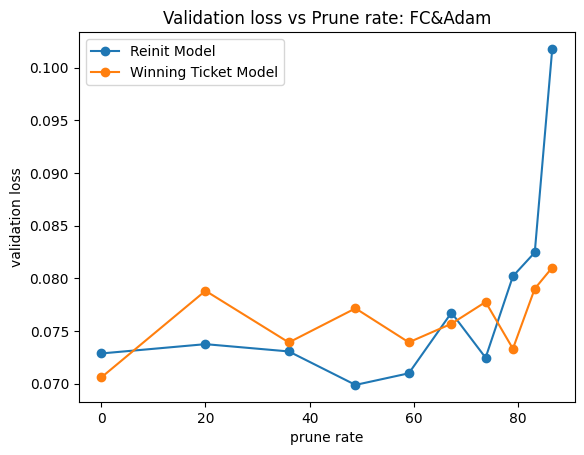

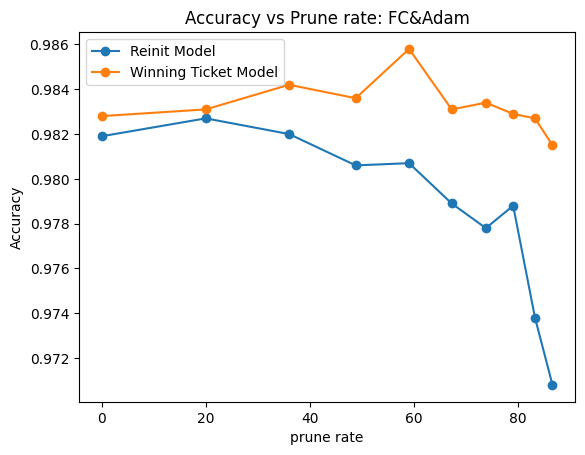

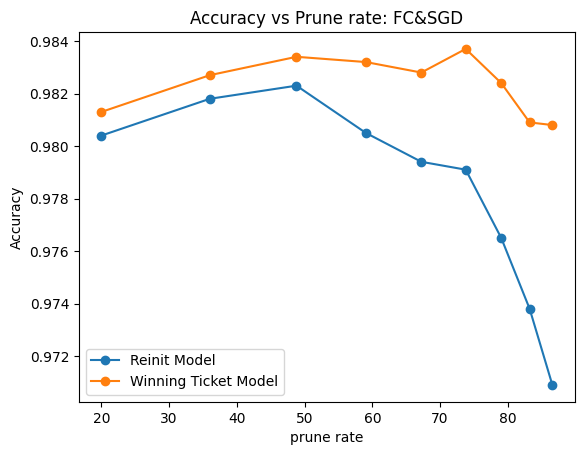

In [32]:
nonzero_param_percent = [100*0.8**i for i in range(10)]
result_reinit_true = torch.load('exp_result/optim_fc/fc_mnist_2_100_0.001_500_reinit-True.pth')
result_reinit_false = torch.load('exp_result/optim_fc/fc_mnist_2_100_0.001_500_reinit-False.pth')
finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/optim_fc/fc_mnist_2_100_0.001_500_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/optim_fc/fc_mnist_2_100_0.001_500_reinit-False_evaluate.pth')
finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.title.set_text('Validation loss vs Prune rate: FC&Adam')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('validation loss')
ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: FC&Adam')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.title.set_text('Validation loss vs Prune rate: FC&SGD')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true_evaluate,'-o',label='Reinit Model')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false_evaluate,'-o',label='Winning Ticket Model')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('validation loss')
# ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: FC&SGD')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

## For Lenet model

In [33]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 10
n_epochs_iterative_prune = 10
num_train = 500
random_seed = 42
reinit = True
batch_size = 16
model_type = 'lenet'
dataset_type = 'mnist'

n_layers = 2
n_neurons = 100

lr = 1e-3
momentum = 0.9
pr = 20 # prune rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# initialize model, optimizer, scheduler, criterion
global model
# For fc, three args are given, n_layers,n_neurons,n_classes
# For lenet,  only n_classes
model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
# initialize store the model parameters
model.apply(init_weight)
store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,'init')
initial_state_dict = copy.deepcopy(model.state_dict())
make_mask(model)

storedPath: ./model_save/lenet_mnist_2_100_0.001_init.pth


In [35]:
def expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device):
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  # initialize model, optimizer, scheduler, criterion
  global model
  model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  # initialize store the model parameters
  model.apply(init_weight)
  store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'init')
  initial_state_dict = copy.deepcopy(model.state_dict())
  make_mask(model)
  # main function
  result_per_iter = {}
  nonzero_param_percent = []
  tickets_path = []
  for iter in tqdm(range(n_epochs_iterative_prune)):
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # initialize the weight after pruning
    if iter != 0:
      prune_layer_wise('percentile',pr)
      if reinit:
        model.apply(init_weight)
        reinitial_state_dict = copy.deepcopy(model.state_dict())
        init_weight_with_mask(mask,reinitial_state_dict)
      else:
        init_weight_with_mask(mask,initial_state_dict)
      # store winning ticket or reinitialized model
      store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'ticket',f'reinit-{reinit}',iter)
      tickets_path.append(store_path)
    nonzero_percent = count_nonzero_param(model)
    print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
    nonzero_param_percent.append(nonzero_percent)
    # train the model for each iteration
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    # result store
    store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'trained',f'reinit-{reinit}',iter)
    result_per_iter[iter] = {'store_path': store_path,
                            'nonzero_percent':nonzero_percent,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/optim_lenet/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}')
  return tickets_path


def evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path):
  tickets_performance = {}
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  global model
  for idx,path in enumerate(tickets_path):
    model = torch.load(path)
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    # training stage
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    tickets_performance[idx] = {
                            'ticket_path': path,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/optim_lenet/',tickets_performance,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}','evaluate')

In [36]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tickets_path1 = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path1)

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.191587288284302, accuracy:0.1135
training_loss:0.31326279044151306
validation_loss:0.23932583131045104, accuracy:0.9314
training_loss:0.06529837101697922
validation_loss:0.08605402047671377, accuracy:0.9721
training_loss:0.0018164280336350203
validation_loss:0.0662998197586974, accuracy:0.9792
training_loss:0.09544355422258377
validation_loss:0.06460463352785446, accuracy:0.9801
training_loss:0.10824016481637955
validation_loss:0.052282550939871, accuracy:0.9831
training_loss:0.0021674425806850195
validation_loss:0.042859703265386635, accuracy:0.987
training_loss:0.0019479031907394528
validation_loss:0.035921882821118925, accuracy:0.9889
training_loss:0.0005177615093998611
validation_loss:0.034865557371464094, accuracy:0.989
training_loss:0.0006639898638240993
validation_loss:0.031770788964082024, accuracy:0.9897
training_loss:0.0005808727000840008


 10%|█         | 1/10 [03:10<28:33, 190.34s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_0.pth
[[[[ 0.40066788 -0.06420583  0.01907432  0.06338601]
   [-0.09961297 -0.11486586 -0.48658976 -0.35437214]
   [ 0.07643438 -0.20247182 -0.6096953  -0.23931833]
   [ 0.18576786 -0.13608886 -0.24812481  0.04861572]]]


 [[[ 0.17860079 -0.18614952 -0.37245926 -0.04709414]
   [ 0.2800974   0.3807123   0.3084326   0.70517266]
   [ 0.23663844  0.41610432  0.4211565   0.22380933]
   [-0.32505164 -0.39741027 -0.22782296 -0.37646803]]]


 [[[-0.04692535 -0.14731197 -0.21943432 -0.5029959 ]
   [-0.41647813 -0.23475151 -0.2609007  -0.17005445]
   [ 0.17240427 -0.05278236  0.00714118 -0.09750723]
   [ 0.46483022  0.524469    0.01850744 -0.03539964]]]


 [[[-0.21282183 -0.2225684  -0.18866672  0.2621836 ]
   [ 0.03957678  0.46346328  0.47251302  0.3611558 ]
   [ 0.34951776  0.26394793  0.04985846 -0.00542252]
   [ 0.13139237 -0.18532097 -0.0721574  -0.30508032]]]


 [[[-0.03662995 -0.02210704  0.9401973   1.0673106 ]
   [

 20%|██        | 2/10 [06:15<24:57, 187.19s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_1.pth
[[[[ 0.2568169   0.         -0.          0.        ]
   [ 0.6138061   0.73253167  0.62024     0.77912086]
   [-0.07850797 -0.23089962 -0.05399887  0.39175248]
   [-0.2800607  -0.266035   -0.15622208 -0.        ]]]


 [[[ 0.39238796  0.35359064  0.0054476  -0.        ]
   [ 0.13316536 -0.10804819 -0.4256011  -0.45564407]
   [ 0.00626892 -0.30949092 -0.37112162 -0.56825525]
   [-0.00123598  0.23037136 -0.23952332 -0.07281805]]]


 [[[-0.          0.348853    0.28931165  0.16334793]
   [ 0.20773906 -0.16605006 -0.40698543 -0.35054532]
   [-0.30949777 -0.         -0.         -0.6725252 ]
   [-0.517624   -0.64255136 -0.          0.        ]]]


 [[[-0.24914019 -0.2454028  -0.18683329 -0.44577393]
   [-0.          0.34424806  0.38895705 -0.2178041 ]
   [ 0.22084068  0.4799537  -0.          0.        ]
   [ 0.12424828  0.30986592  0.         -0.07216657]]]


 [[[-0.         -0.         -0.5422265  -0.39123026]
   [

 30%|███       | 3/10 [09:29<22:13, 190.55s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_2.pth
[[[[ 2.3588781e-01  0.0000000e+00  0.0000000e+00 -0.0000000e+00]
   [ 4.8280218e-01  7.0491719e-01  7.7850610e-01  8.5204113e-01]
   [ 0.0000000e+00 -5.9917316e-02 -0.0000000e+00  3.8717305e-03]
   [-1.6623043e-02 -3.4481013e-01 -3.4667110e-01  0.0000000e+00]]]


 [[[ 2.9555878e-01  4.8342556e-01 -0.0000000e+00  0.0000000e+00]
   [ 7.8294970e-02  0.0000000e+00 -1.5704390e-01  5.0965130e-02]
   [-0.0000000e+00 -4.2472655e-01 -3.3217871e-01 -2.1555836e-01]
   [-0.0000000e+00 -7.4757114e-03 -2.7390426e-01 -0.0000000e+00]]]


 [[[-0.0000000e+00  1.6104107e-01  8.7543725e-05 -2.5253293e-01]
   [ 3.4721377e-01  9.3624860e-02 -2.4089903e-01 -1.7456169e-01]
   [ 9.2418507e-02  0.0000000e+00  0.0000000e+00 -4.0312636e-01]
   [ 1.0712577e-01 -1.5299018e-01  0.0000000e+00 -0.0000000e+00]]]


 [[[-3.8232645e-01 -2.8939670e-01  2.4731617e-01  7.5000185e-01]
   [ 0.0000000e+00  4.3160060e-01  6.0192132e-01 -1.3178933e-01]

 40%|████      | 4/10 [2:37:53<6:03:03, 3630.55s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_3.pth
[[[[ 0.57334685 -0.         -0.          0.        ]
   [ 0.44346207  0.6107779   0.7804573   1.052768  ]
   [-0.          0.          0.         -0.        ]
   [-0.         -0.3044693  -0.16393135  0.        ]]]


 [[[ 0.33012202  0.11966385  0.          0.        ]
   [-0.         -0.          0.40542048  0.        ]
   [-0.          0.24269593  0.26001593 -0.0028085 ]
   [ 0.          0.         -0.33974266  0.        ]]]


 [[[-0.          0.21408917 -0.         -0.07238826]
   [ 0.25026223  0.         -0.53662264 -0.59175456]
   [-0.         -0.         -0.         -0.18168207]
   [ 0.38749704  0.11782283 -0.         -0.        ]]]


 [[[-0.451577   -0.18142168  0.12539537  0.41932595]
   [-0.          0.18557103  0.90678406  0.37927854]
   [ 0.10504839  0.7477173   0.         -0.        ]
   [ 0.5690598   0.57127964  0.          0.        ]]]


 [[[-0.          0.          0.39074302  0.38162753]
   [

 50%|█████     | 5/10 [2:41:11<3:19:23, 2392.60s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_4.pth
[[[[ 0.5051056  -0.         -0.         -0.        ]
   [ 0.21915661 -0.16753756 -0.01381304  0.03228156]
   [-0.         -0.          0.         -0.        ]
   [ 0.         -0.6049189  -0.42633426 -0.        ]]]


 [[[-0.38833007  0.          0.         -0.        ]
   [-0.         -0.          0.61881834 -0.        ]
   [-0.          0.49893588  0.39293462 -0.        ]
   [-0.          0.          0.3532445  -0.        ]]]


 [[[ 0.         -0.13320184 -0.          0.        ]
   [ 0.08451828  0.          0.31034583  0.3821598 ]
   [-0.          0.         -0.          0.41888195]
   [ 0.61292    -0.          0.         -0.        ]]]


 [[[-0.05847951 -0.40509596  0.         -0.30926222]
   [ 0.         -0.46072257 -0.66273415 -0.61647695]
   [ 0.         -0.12735535  0.          0.        ]
   [ 0.34859112  0.03843813  0.         -0.        ]]]


 [[[-0.         -0.         -0.13491116 -0.26547784]
   [

 60%|██████    | 6/10 [2:44:28<1:49:44, 1646.21s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_5.pth
[[[[-0.6531135  -0.          0.         -0.        ]
   [-0.27963084 -0.49627864  0.         -0.        ]
   [ 0.          0.          0.          0.        ]
   [-0.          0.47516683  0.7313071  -0.        ]]]


 [[[ 0.7857995  -0.          0.         -0.        ]
   [-0.          0.          0.9099107  -0.        ]
   [-0.          0.06231238  0.04424446 -0.        ]
   [ 0.          0.         -0.43828544  0.        ]]]


 [[[ 0.          0.11714079 -0.         -0.        ]
   [ 0.         -0.          0.10019131  0.43891683]
   [-0.          0.          0.          0.34791473]
   [-0.04334528  0.         -0.          0.        ]]]


 [[[ 0.          0.0960343  -0.          0.17957628]
   [ 0.         -0.96733856 -0.45376098 -0.8421979 ]
   [-0.         -0.         -0.         -0.        ]
   [ 0.36438963  0.         -0.         -0.        ]]]


 [[[ 0.          0.         -0.08655544 -0.836513  ]
   [

 70%|███████   | 7/10 [2:47:43<58:34, 1171.52s/it]  

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_6.pth
[[[[-0.5126296  -0.          0.          0.        ]
   [-0.2866457  -0.766067   -0.          0.        ]
   [-0.          0.          0.          0.        ]
   [-0.         -0.71754766 -0.6927862  -0.        ]]]


 [[[ 0.67301625  0.          0.          0.        ]
   [ 0.         -0.         -0.06515734  0.        ]
   [ 0.          0.         -0.          0.        ]
   [-0.         -0.         -0.9705013  -0.        ]]]


 [[[ 0.          0.84326446 -0.          0.        ]
   [ 0.         -0.         -0.          0.20875096]
   [-0.          0.         -0.          0.18510795]
   [ 0.         -0.          0.         -0.        ]]]


 [[[ 0.          0.         -0.          0.187533  ]
   [-0.         -0.44241095  0.4880492   0.8777982 ]
   [ 0.         -0.         -0.         -0.        ]
   [-0.2505876   0.         -0.          0.        ]]]


 [[[ 0.         -0.         -0.         -0.88001204]
   [

 80%|████████  | 8/10 [2:50:58<28:41, 860.64s/it] 

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_7.pth
[[[[ 0.77839446 -0.          0.         -0.        ]
   [ 0.27745703  0.8016076   0.          0.        ]
   [-0.          0.          0.          0.        ]
   [-0.          0.1123493   0.83576614  0.        ]]]


 [[[ 0.36002612 -0.          0.         -0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.         -0.          0.         -0.        ]
   [ 0.          0.         -0.68488294  0.        ]]]


 [[[-0.         -0.55178255 -0.         -0.        ]
   [ 0.          0.          0.         -0.        ]
   [ 0.         -0.          0.          0.        ]
   [ 0.         -0.          0.          0.        ]]]


 [[[-0.          0.          0.          0.        ]
   [-0.          0.36329857  0.43063942  0.76633084]
   [ 0.         -0.         -0.          0.        ]
   [ 0.         -0.         -0.          0.        ]]]


 [[[-0.         -0.          0.          0.85449946]
   [

 90%|█████████ | 9/10 [2:54:11<10:52, 652.07s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_8.pth
[[[[ 0.7638876  -0.          0.         -0.        ]
   [ 0.          0.539033    0.         -0.        ]
   [ 0.          0.         -0.          0.        ]
   [ 0.         -0.          0.30361956  0.        ]]]


 [[[ 0.          0.         -0.         -0.        ]
   [ 0.         -0.          0.         -0.        ]
   [ 0.         -0.          0.          0.        ]
   [-0.         -0.          1.1078947   0.        ]]]


 [[[-0.         -0.596857   -0.         -0.        ]
   [-0.          0.          0.         -0.        ]
   [ 0.          0.         -0.         -0.        ]
   [ 0.          0.          0.         -0.        ]]]


 [[[ 0.          0.          0.          0.        ]
   [ 0.         -0.          0.47896892  0.83546084]
   [ 0.          0.          0.          0.        ]
   [ 0.          0.          0.         -0.        ]]]


 [[[ 0.         -0.          0.          0.39333105]
   [

100%|██████████| 10/10 [2:57:28<00:00, 1064.85s/it]


storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-True_9.pth
storedPath: ./exp_result/optim_lenet/lenet_mnist_2_100_0.001_500_reinit-True.pth
storedPath: ./model_save/lenet_mnist_2_100_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.130268257522583, accuracy:0.1009
training_loss:0.5650660991668701
validation_loss:0.17612356455922126, accuracy:0.9477
training_loss:0.045556921511888504
validation_loss:0.07999009064082056, accuracy:0.9757
training_loss:0.005365778226405382
validation_loss:0.08138082215446048, accuracy:0.9718
training_loss:0.152186319231987
validation_loss:0.06351964500504546, accuracy:0.9807
training_loss:0.0022126741241663694
validation_loss:0.04812237346526235, accuracy:0.9847
training_loss:0.00420784717425704
validation_loss:0.033497651521395895, accuracy:0.9899
training_loss:0.0020509057212620974
validation_loss:0.029978085551090772, accuracy:0.9907
training_loss:0.0008351555443368852
validation_loss:0.026637431607936742, accuracy:0.9913
training_loss:0.00022539973724633455
validation_loss:0.025237410178847494, accuracy:0.9918
training_loss:0.0004640640690922737


 10%|█         | 1/10 [03:15<29:21, 195.76s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_0.pth
[[[[-0.03771339 -0.05806739  0.16395022  0.6007147 ]
   [-0.11614874 -0.16555604 -0.02983312  0.69328046]
   [-0.2029695  -0.02095905  0.32087475  0.26690394]
   [-0.0276996   0.15569147  0.50386715  0.25506124]]]


 [[[ 0.06047696 -0.08783159 -0.1316325  -0.27715755]
   [ 0.13672009  0.10294867 -0.11551854 -0.46933055]
   [-0.18103576  0.00619857  0.01912306  0.26951393]
   [ 0.07027919 -0.00313852  0.49871352  0.6218914 ]]]


 [[[ 0.30560628  0.04032713 -0.1017496   0.13364403]
   [ 0.01054365  0.06667498  0.23929532  0.0393844 ]
   [-0.2894869  -0.03673597 -0.14576915 -0.19512372]
   [-0.6937549  -0.62939703 -0.5170358  -0.6829566 ]]]


 [[[ 0.47399935  0.24127407 -0.03517911 -0.03140403]
   [ 0.12794933 -0.0901964  -0.2007711  -0.246768  ]
   [ 0.05468674 -0.06517183 -0.41526514 -0.08058777]
   [ 0.20049779  0.04162418 -0.2967178  -0.09216532]]]


 [[[-0.2824808  -0.13321637  0.15649149  0.3177522 ]
   

 20%|██        | 2/10 [06:32<26:08, 196.05s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_1.pth
[[[[-0.         -0.          0.1447542   0.58733016]
   [-0.15441678 -0.21127386 -0.          0.66052216]
   [-0.19055341  0.          0.271582    0.2593071 ]
   [ 0.          0.07138466  0.4021829   0.30279076]]]


 [[[ 0.06687167 -0.06156321 -0.1104475  -0.29789174]
   [ 0.1430505   0.12798658 -0.07987331 -0.46583956]
   [-0.18934856 -0.          0.          0.3125822 ]
   [ 0.04041646 -0.          0.42551652  0.6031553 ]]]


 [[[ 0.24427131 -0.         -0.06569035  0.14276387]
   [-0.          0.07131841  0.22748868 -0.        ]
   [-0.19974202  0.         -0.15264417 -0.16565512]
   [-0.7189845  -0.6514003  -0.5131167  -0.67031324]]]


 [[[ 0.39281896  0.21262404 -0.         -0.        ]
   [ 0.25157428 -0.0279824  -0.131278   -0.03947752]
   [ 0.         -0.1332098  -0.40077004 -0.11029407]
   [ 0.08531128 -0.         -0.18216842 -0.16258895]]]


 [[[-0.26463243 -0.11962956  0.16385294  0.25528824]
   

 30%|███       | 3/10 [09:49<22:56, 196.62s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_2.pth
[[[[-0.         -0.          0.11001331  0.5351129 ]
   [-0.14308564 -0.1812463  -0.          0.6113149 ]
   [-0.15570228  0.          0.22571036  0.28244418]
   [ 0.          0.          0.37054807  0.3230923 ]]]


 [[[ 0.         -0.          0.         -0.290866  ]
   [ 0.13416505  0.10685413  0.         -0.4415069 ]
   [-0.20407887 -0.          0.          0.28736255]
   [ 0.         -0.          0.32350892  0.56018716]]]


 [[[ 0.27541998 -0.         -0.          0.13527022]
   [-0.         -0.          0.20287903 -0.        ]
   [-0.17439342  0.         -0.16931364 -0.11625002]
   [-0.67217803 -0.577085   -0.44997138 -0.6766752 ]]]


 [[[ 0.3985015   0.19404213 -0.         -0.        ]
   [ 0.22757271 -0.         -0.08207425 -0.        ]
   [ 0.         -0.18779157 -0.38098916 -0.        ]
   [ 0.         -0.         -0.19115601 -0.2593562 ]]]


 [[[-0.19320036 -0.0316239   0.22304285  0.26926976]
   

 40%|████      | 4/10 [13:03<19:34, 195.71s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_3.pth
[[[[-0.         -0.          0.          0.56477815]
   [-0.         -0.30984822 -0.          0.61428165]
   [-0.          0.          0.18056896  0.25883305]
   [ 0.          0.          0.33889824  0.33189344]]]


 [[[ 0.         -0.          0.         -0.2665044 ]
   [ 0.          0.          0.         -0.39359632]
   [-0.13545178 -0.          0.          0.31465915]
   [ 0.         -0.          0.3621408   0.51558876]]]


 [[[ 0.2387975  -0.         -0.          0.        ]
   [-0.         -0.          0.2379646  -0.        ]
   [-0.14028347  0.         -0.         -0.        ]
   [-0.64062077 -0.52296776 -0.43630627 -0.7530746 ]]]


 [[[ 0.3928164   0.18029402 -0.         -0.        ]
   [ 0.23142834 -0.          0.         -0.        ]
   [ 0.         -0.18584037 -0.405936   -0.        ]
   [ 0.         -0.         -0.19683817 -0.2746737 ]]]


 [[[-0.18487082 -0.          0.23754689  0.31591496]
   

 50%|█████     | 5/10 [5:46:37<10:11:51, 7342.38s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_4.pth
[[[[-0.         -0.          0.          0.5111799 ]
   [-0.         -0.27583522 -0.          0.63582546]
   [-0.          0.          0.          0.36763385]
   [ 0.          0.          0.4041758   0.359774  ]]]


 [[[ 0.         -0.          0.         -0.31796527]
   [ 0.          0.          0.         -0.41865513]
   [-0.         -0.          0.          0.31014854]
   [ 0.         -0.          0.33814546  0.5664606 ]]]


 [[[ 0.2185798  -0.         -0.          0.        ]
   [-0.         -0.          0.22306822 -0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.69636023 -0.53079045 -0.41090852 -0.73244023]]]


 [[[ 0.4193438  -0.         -0.         -0.        ]
   [ 0.14673455 -0.          0.         -0.        ]
   [ 0.         -0.         -0.46157312 -0.        ]
   [ 0.         -0.         -0.         -0.34898746]]]


 [[[ 0.         -0.          0.25585282  0.34783286]
   

 60%|██████    | 6/10 [5:49:41<5:27:14, 4908.60s/it] 

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_5.pth
[[[[-0.         -0.          0.          0.5879047 ]
   [-0.         -0.31044874 -0.          0.6588063 ]
   [-0.          0.          0.          0.3765776 ]
   [ 0.          0.          0.3548846   0.41439483]]]


 [[[ 0.         -0.          0.         -0.33087632]
   [ 0.          0.          0.         -0.41335797]
   [-0.         -0.          0.          0.32043517]
   [ 0.         -0.          0.35605797  0.59416187]]]


 [[[ 0.         -0.         -0.          0.        ]
   [-0.         -0.          0.         -0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.73179    -0.5271879  -0.42338964 -0.8794016 ]]]


 [[[ 0.48324186 -0.         -0.         -0.        ]
   [ 0.         -0.          0.         -0.        ]
   [ 0.         -0.         -0.43003264 -0.        ]
   [ 0.         -0.         -0.         -0.3182115 ]]]


 [[[ 0.         -0.          0.          0.4708852 ]
   

 70%|███████   | 7/10 [5:53:03<2:48:28, 3369.66s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_6.pth
[[[[-0.         -0.          0.          0.570453  ]
   [-0.         -0.         -0.          0.6466144 ]
   [-0.          0.          0.          0.37911817]
   [ 0.          0.          0.33744964  0.43138707]]]


 [[[ 0.         -0.          0.         -0.        ]
   [ 0.          0.          0.         -0.42839622]
   [-0.         -0.          0.          0.        ]
   [ 0.         -0.          0.3597291   0.6361335 ]]]


 [[[ 0.         -0.         -0.          0.        ]
   [-0.         -0.          0.         -0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.80009496 -0.54125977 -0.4504941  -0.9404815 ]]]


 [[[ 0.42818752 -0.         -0.         -0.        ]
   [ 0.         -0.          0.         -0.        ]
   [ 0.         -0.         -0.5973031  -0.        ]
   [ 0.         -0.         -0.         -0.        ]]]


 [[[ 0.         -0.          0.          0.48111975]
   

 80%|████████  | 8/10 [5:56:22<1:18:40, 2360.41s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_7.pth
[[[[-0.         -0.          0.          0.5471349 ]
   [-0.         -0.         -0.          0.78971076]
   [-0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.71602803]]]


 [[[ 0.         -0.          0.         -0.        ]
   [ 0.          0.          0.         -0.28848624]
   [-0.         -0.          0.          0.        ]
   [ 0.         -0.          0.          0.77961934]]]


 [[[ 0.         -0.         -0.          0.        ]
   [-0.         -0.          0.         -0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.7697257  -0.52486    -0.4598157  -0.8754855 ]]]


 [[[ 0.         -0.         -0.         -0.        ]
   [ 0.         -0.          0.         -0.        ]
   [ 0.         -0.         -0.57651705 -0.        ]
   [ 0.         -0.         -0.         -0.        ]]]


 [[[ 0.         -0.          0.          0.46330628]
   

 90%|█████████ | 9/10 [5:59:41<28:04, 1684.56s/it]  

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_8.pth
[[[[-0.         -0.          0.          0.58236974]
   [-0.         -0.         -0.          0.793964  ]
   [-0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.8139003 ]]]


 [[[ 0.         -0.          0.         -0.        ]
   [ 0.          0.          0.         -0.        ]
   [-0.         -0.          0.          0.        ]
   [ 0.         -0.          0.          0.66501087]]]


 [[[ 0.         -0.         -0.          0.        ]
   [-0.         -0.          0.         -0.        ]
   [-0.          0.         -0.         -0.        ]
   [-0.84719986 -0.7872453   0.         -1.0154136 ]]]


 [[[ 0.         -0.         -0.         -0.        ]
   [ 0.         -0.          0.         -0.        ]
   [ 0.         -0.         -0.6172632  -0.        ]
   [ 0.         -0.         -0.         -0.        ]]]


 [[[ 0.         -0.          0.         -0.        ]
   

100%|██████████| 10/10 [6:02:59<00:00, 2177.95s/it]

storedPath: ./model_save/lenet_mnist_2_100_0.001_500_trained_reinit-False_9.pth
storedPath: ./exp_result/optim_lenet/lenet_mnist_2_100_0.001_500_reinit-False.pth


validation_loss:3.695692943191528, accuracy:0.0958
training_loss:0.10678841918706894
validation_loss:0.11905113723576069, accuracy:0.9632
training_loss:0.021985037252306938
validation_loss:0.06737101477831602, accuracy:0.9788
training_loss:0.49383866786956787
validation_loss:0.05923133966512978, accuracy:0.9814
training_loss:0.1614827662706375
validation_loss:0.04169250086111715, accuracy:0.9863
training_loss:0.014288070611655712
validation_loss:0.04428636940307915, accuracy:0.9859
training_loss:0.03279192000627518
validation_loss:0.03136877266290831, accuracy:0.9899
training_loss:0.008758698590099812
validation_loss:0.033486403234564935, accuracy:0.9897
training_loss:0.00116330839227885
validation_loss:0.028514823936688482, accuracy:0.9911
training_loss:0.0007179130334407091
validation_loss:0.02938880314800772, accuracy:0.9911
training_loss:0.0002675256982911378
validation_loss:2.898185617828369, accuracy:0.098
training_loss:0.4423334002494812
validation_loss:0.14461563321202994, accu

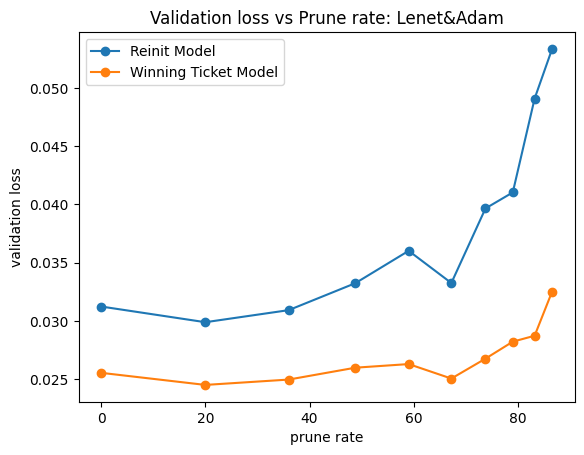

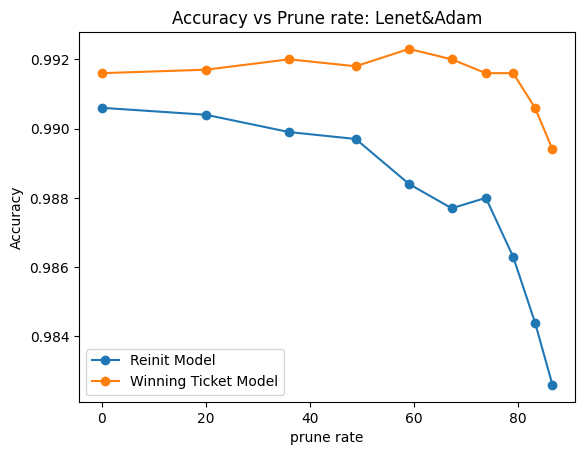

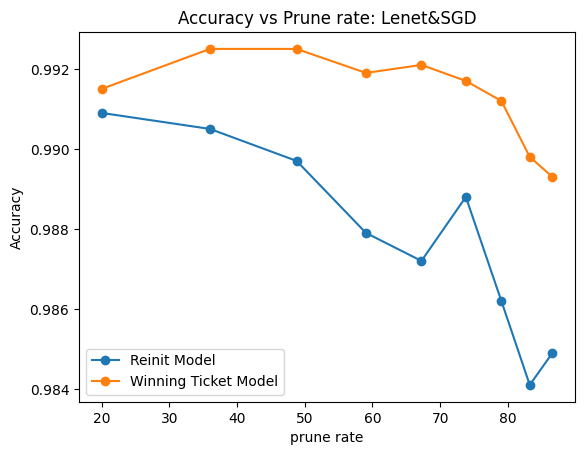

In [37]:
nonzero_param_percent = [100*0.8**i for i in range(10)]
result_reinit_true = torch.load('exp_result/optim_lenet/lenet_mnist_2_100_0.001_500_reinit-True.pth')
result_reinit_false = torch.load('exp_result/optim_lenet/lenet_mnist_2_100_0.001_500_reinit-False.pth')
finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/optim_lenet/lenet_mnist_2_100_0.001_500_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/optim_lenet/lenet_mnist_2_100_0.001_500_reinit-False_evaluate.pth')
finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.title.set_text('Validation loss vs Prune rate: Lenet&Adam')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('validation loss')
ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: Lenet&Adam')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.title.set_text('Validation loss vs Prune rate: Lenet&SGD')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true_evaluate,'-o',label='Reinit Model')
# ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false_evaluate,'-o',label='Winning Ticket Model')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('validation loss')
# ax.legend()

fig,ax = plt.subplots()
ax.title.set_text('Accuracy vs Prune rate: Lenet&SGD')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='Reinit Model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='Winning Ticket Model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# Experiment analysis: Optimizer Difference with small case size


In [38]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 10
n_epochs_iterative_prune = 10
num_train = 500
random_seed = 42
reinit = True
batch_size = 16
model_type = 'fc'
dataset_type = 'mnist'

# n_layers = 2
# n_neurons = 100

#example 1
n_layers = 1
n_neurons = 10

lr = 1e-3
momentum = 0.9
pr = 20 # prune rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# initialize model, optimizer, scheduler, criterion
global model
# For fc, three args are given, n_layers,n_neurons,n_classes
# For lenet,  only n_classes
model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
# initialize store the model parameters
model.apply(init_weight)
store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,'init')
initial_state_dict = copy.deepcopy(model.state_dict())
make_mask(model)

storedPath: ./model_save/fc_mnist_1_10_0.001_init.pth


In [40]:
def expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device):
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  # initialize model, optimizer, scheduler, criterion
  global model
  model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  # initialize store the model parameters
  model.apply(init_weight)
  store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'init')
  initial_state_dict = copy.deepcopy(model.state_dict())
  make_mask(model)
  # main function
  result_per_iter = {}
  nonzero_param_percent = []
  tickets_path = []
  for iter in tqdm(range(n_epochs_iterative_prune)):
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # initialize the weight after pruning
    if iter != 0:
      prune_layer_wise('percentile',pr)
      if reinit:
        model.apply(init_weight)
        reinitial_state_dict = copy.deepcopy(model.state_dict())
        init_weight_with_mask(mask,reinitial_state_dict)
      else:
        init_weight_with_mask(mask,initial_state_dict)
      # store winning ticket or reinitialized model
      store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'ticket',f'reinit-{reinit}',iter)
      tickets_path.append(store_path)
    nonzero_percent = count_nonzero_param(model)
    print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
    nonzero_param_percent.append(nonzero_percent)
    # train the model for each iteration
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    # result store
    store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'trained',f'reinit-{reinit}',iter)
    result_per_iter[iter] = {'store_path': store_path,
                            'nonzero_percent':nonzero_percent,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}')
  return tickets_path


def evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path):
  tickets_performance = {}
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  global model
  for idx,path in enumerate(tickets_path):
    model = torch.load(path)
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    # training stage
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    tickets_performance[idx] = {
                            'ticket_path': path,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/',tickets_performance,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}','evaluate')

In [41]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
tickets_path1 = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)

storedPath: ./model_save/fc_mnist_1_10_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.720551156234741, accuracy:0.0932
training_loss:0.4706629812717438
validation_loss:0.41127209267020226, accuracy:0.8869
training_loss:0.061745867133140564
validation_loss:0.2825269752435386, accuracy:0.9181
training_loss:0.12433616816997528
validation_loss:0.2678754904098809, accuracy:0.924
training_loss:0.374843031167984
validation_loss:0.2593722149346024, accuracy:0.923
training_loss:0.1565466821193695
validation_loss:0.22578421009667218, accuracy:0.9364
training_loss:0.15671926736831665
validation_loss:0.21803003963679074, accuracy:0.9366
training_loss:0.019215472042560577
validation_loss:0.21063113028518857, accuracy:0.9394
training_loss:0.3499756455421448
validation_loss:0.21045214469991624, accuracy:0.9405
training_loss:0.2714520990848541
validation_loss:0.20639028320200742, accuracy:0.9411
training_loss:0.04920989274978638


 10%|█         | 1/10 [02:07<19:09, 127.69s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_0.pth
[[ 0.0428994  -0.08425932  0.0641189  ... -0.06236928 -0.01014891
  -0.00020305]
 [-0.08529478  0.00231718  0.01873443 ... -0.01653358  0.10318991
  -0.05118812]
 [-0.04575704 -0.02633597 -0.05679625 ... -0.05970072 -0.01379787
  -0.02520185]
 ...
 [ 0.02026909 -0.04392818  0.00850075 ...  0.04886072  0.09896047
   0.05790349]
 [-0.02056183 -0.07822084 -0.04820798 ... -0.02603706 -0.08215741
   0.03548414]
 [ 0.08257835  0.00102176 -0.02976937 ...  0.01953173  0.07047153
  -0.0826632 ]]
[ 0.0428994  -0.08425932  0.0641189  ...  0.01953173  0.07047153
 -0.0826632 ]
0.024480176717042928
[[-3.21840644e-01  4.80246782e-01  2.35488668e-01 -4.71420348e-01
   1.68940201e-02  1.01508468e-01  6.26328826e-01 -4.08084780e-01
  -1.28021315e-01 -4.07404274e-01]
 [-2.86043078e-01  1.13615133e-01 -3.38789463e-01  4.88850117e-01
  -6.33950531e-01 -3.50259066e-01 -3.74632090e-01  1.54939383e-01
  -1.64893851e-01  6.85928702e-01]

 20%|██        | 2/10 [04:10<16:36, 124.60s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_1.pth
[[-0.00533299 -0.12710103 -0.04641409 ... -0.03139736  0.
   0.        ]
 [ 0.18738414  0.         -0.         ...  0.          0.01612052
   0.07490496]
 [-0.02325438  0.03376121  0.0430195  ... -0.09949621  0.
   0.01828321]
 ...
 [-0.         -0.00036844 -0.         ... -0.0177334  -0.04285441
   0.03722716]
 [ 0.          0.0015866   0.05809926 ... -0.00323656  0.05032564
   0.03320358]
 [ 0.04068121  0.          0.07664511 ...  0.         -0.01152107
   0.1264777 ]]
[-0.00533299 -0.12710103 -0.04641409 ... -0.03140536 -0.01152107
  0.1264777 ]
0.028495830297470093
[[-1.92690760e-01 -2.76798248e-01  3.56294125e-01 -1.14022486e-01
  -0.00000000e+00  3.07809263e-01 -5.11366308e-01 -8.20846930e-02
  -3.35038841e-01  6.79073751e-01]
 [-4.97800440e-01 -1.16073512e-01  5.94639294e-02  3.81351322e-01
  -2.77767420e-01 -3.95810634e-01 -6.73918009e-01 -1.75038189e-01
   5.76284230e-01  2.33991221e-01]
 [ 1.16241030e-

 30%|███       | 3/10 [06:12<14:26, 123.80s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_2.pth
[[ 0.         -0.07597321 -0.16503195 ...  0.01460953  0.
   0.        ]
 [ 0.03820314  0.          0.         ...  0.         -0.
   0.06057251]
 [ 0.         -0.05353757  0.04335079 ...  0.00075439 -0.
  -0.        ]
 ...
 [ 0.         -0.         -0.         ...  0.         -0.03448311
  -0.02455515]
 [-0.         -0.          0.02338586 ... -0.         -0.04530857
  -0.02494002]
 [ 0.10684872 -0.         -0.0484064  ...  0.         -0.
   0.0282197 ]]
[-0.07597321 -0.16503195  0.05921692 ...  0.02419418 -0.04850708
  0.0282197 ]
0.027709005773067476
[[ 0.7260408  -0.40484193 -0.68514353  0.         -0.          0.15075743
  -0.3640813  -0.          0.06368685  0.09304644]
 [-0.9842076  -0.          0.          0.7700822   0.35266653 -0.05760846
  -0.38318855 -0.4963677   0.0570947   0.69898695]
 [ 0.14262652 -0.         -0.          0.04954772  0.          0.1578916
  -0.09125658  0.27925485  0.9337473   0.0

 40%|████      | 4/10 [08:20<12:31, 125.24s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_3.pth
[[-0.         -0.10603023 -0.1644615  ...  0.         -0.
   0.        ]
 [ 0.08061925  0.          0.         ...  0.         -0.
   0.07662147]
 [-0.          0.00301052 -0.1504827  ...  0.         -0.
  -0.        ]
 ...
 [-0.         -0.          0.         ... -0.         -0.12819837
   0.        ]
 [ 0.          0.         -0.         ... -0.         -0.02892132
  -0.        ]
 [ 0.02804664 -0.          0.05398022 ...  0.          0.
   0.02610835]]
[-0.10603023 -0.1644615  -0.12727077 ...  0.01776166  0.08200803
  0.02610835]
0.037281107157468796
[[-0.83873767 -0.28916073  0.160385    0.         -0.         -0.31519195
   0.29304805  0.         -0.          0.63777226]
 [ 0.7919775  -0.          0.         -0.48700592  0.68422216  0.
  -0.984854   -0.61864156 -0.         -0.22447355]
 [ 0.5034436   0.          0.         -0.         -0.          0.31835583
  -0.          0.33302602 -0.8888183  -0.        

 50%|█████     | 5/10 [10:22<10:21, 124.25s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_4.pth
[[ 0.         -0.20375167 -0.1325715  ...  0.         -0.
   0.        ]
 [ 0.04675934  0.         -0.         ... -0.         -0.
  -0.01285409]
 [ 0.          0.         -0.2003069  ...  0.          0.
  -0.        ]
 ...
 [ 0.          0.          0.         ... -0.         -0.03589365
   0.        ]
 [-0.          0.          0.         ...  0.         -0.
   0.        ]
 [-0.         -0.          0.11436769 ... -0.          0.
  -0.        ]]
[-0.20375167 -0.1325715  -0.1776442  ...  0.15230474  0.05062304
 -0.05070299]
0.030669898912310607
[[-0.37034956  0.9497578  -0.         -0.         -0.          0.21683073
  -0.2315386  -0.          0.         -1.0243871 ]
 [-0.13686903 -0.          0.         -0.5848425   0.61811864  0.
  -0.6292051   0.3152716   0.          0.867514  ]
 [-0.3502289  -0.          0.          0.          0.          0.09957469
  -0.          0.4156749   1.3165634  -0.        ]
 [ 0. 

 60%|██████    | 6/10 [12:25<08:14, 123.55s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_5.pth
[[-0.          0.02733388 -0.00573112 ... -0.         -0.
   0.        ]
 [-0.15477283  0.         -0.         ... -0.          0.
   0.        ]
 [-0.          0.          0.08041412 ...  0.          0.
  -0.        ]
 ...
 [ 0.          0.         -0.         ... -0.         -0.05143796
   0.        ]
 [-0.          0.         -0.         ... -0.         -0.
  -0.        ]
 [-0.          0.          0.03527616 ...  0.         -0.
  -0.        ]]
[ 0.02733388 -0.00573112  0.04493864 ...  0.03100681  0.00427295
  0.04599609]
0.04193535521626472
[[-0.30383548 -0.95048916  0.         -0.          0.          0.05270706
   0.77217036 -0.          0.         -0.7265518 ]
 [ 0.14017911 -0.          0.          0.7588721  -1.3116101   0.
   0.06036434 -0.17285827 -0.          0.01692311]
 [ 0.39057094 -0.         -0.         -0.          0.          0.
  -0.          0.7256144  -0.8111162  -0.        ]
 [-0.         -

 70%|███████   | 7/10 [14:32<06:14, 124.93s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_6.pth
[[-0.         -0.          0.         ... -0.         -0.
   0.        ]
 [-0.20718504 -0.         -0.         ... -0.          0.
  -0.        ]
 [ 0.         -0.         -0.3141494  ... -0.          0.
  -0.        ]
 ...
 [-0.         -0.          0.         ... -0.         -0.1353987
  -0.        ]
 [ 0.         -0.         -0.         ...  0.         -0.
   0.        ]
 [-0.          0.         -0.         ...  0.         -0.
   0.        ]]
[-0.02037799 -0.031694   -0.00270748 ...  0.01126717  0.02207421
 -0.07456741]
0.05121152549982071
[[-0.00383739 -0.8511501  -0.          0.          0.         -0.
   0.95075125 -0.          0.          0.02008499]
 [ 0.          0.         -0.         -0.68674785 -1.7806076  -0.
   0.          0.81683564 -0.         -0.        ]
 [-0.31339988  0.          0.         -0.          0.         -0.
  -0.          0.8822973  -0.56757635 -0.        ]
 [-0.         -0.       

 80%|████████  | 8/10 [16:34<04:07, 123.89s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_7.pth
[[-0.         -0.          0.         ... -0.         -0.
  -0.        ]
 [ 0.0631344  -0.          0.         ...  0.         -0.
   0.        ]
 [-0.         -0.         -0.28018746 ... -0.         -0.
   0.        ]
 ...
 [-0.         -0.          0.         ...  0.         -0.19324915
   0.        ]
 [-0.         -0.          0.         ...  0.         -0.
   0.        ]
 [-0.          0.         -0.         ...  0.          0.
  -0.        ]]
[-0.08876805 -0.21465163 -0.12418621 ...  0.22909167  0.22005938
 -0.16232719]
0.07432138621807101
[[ 0.          1.0613084  -0.          0.          0.          0.
  -0.85994613 -0.          0.          0.        ]
 [-0.          0.         -0.          0.38285044 -1.2869325  -0.
  -0.          0.872923    0.          0.        ]
 [ 0.43874815  0.         -0.         -0.          0.         -0.
  -0.          0.32017547 -0.80300504  0.        ]
 [-0.          0.      

 90%|█████████ | 9/10 [18:32<02:02, 122.12s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_8.pth
[[-0.          0.         -0.         ...  0.          0.
  -0.        ]
 [-0.         -0.          0.         ...  0.          0.
   0.        ]
 [-0.          0.          0.26535955 ... -0.         -0.
  -0.        ]
 ...
 [ 0.         -0.          0.         ...  0.         -0.38123533
   0.        ]
 [ 0.         -0.          0.         ... -0.          0.
  -0.        ]
 [-0.          0.         -0.         ... -0.          0.
   0.        ]]
[-0.29497963 -0.16572945 -0.17307834 ...  0.17797925  0.10437313
 -0.09622282]
0.07128691673278809
[[ 0.         -1.2314823  -0.         -0.          0.         -0.
   0.484974    0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.3831642   0.
   0.          0.5877684  -0.          0.        ]
 [-0.14463118 -0.          0.         -0.          0.          0.
   0.          0.          1.0344902   0.        ]
 [ 0.         -0.      

100%|██████████| 10/10 [20:37<00:00, 123.78s/it]


storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-True_9.pth
storedPath: ./exp_result/fc_mnist_1_10_0.001_500_reinit-True.pth
storedPath: ./model_save/fc_mnist_1_10_0.001_500_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.436758527755737, accuracy:0.1057
training_loss:0.4293775260448456
validation_loss:0.47797461615800857, accuracy:0.8691
training_loss:0.391038715839386
validation_loss:0.2906223607316613, accuracy:0.9169
training_loss:0.29574623703956604
validation_loss:0.2730360093684867, accuracy:0.9233
training_loss:0.11922144889831543
validation_loss:0.24722418372444807, accuracy:0.9307
training_loss:0.11392075568437576
validation_loss:0.2322850341267884, accuracy:0.9361
training_loss:0.17305625975131989
validation_loss:0.2331706777079031, accuracy:0.9364
training_loss:0.04559553414583206
validation_loss:0.23126833191532642, accuracy:0.9335
training_loss:0.7051276564598083
validation_loss:0.21049349835161119, accuracy:0.9423
training_loss:0.15586453676223755
validation_loss:0.20524329252839088, accuracy:0.9435
training_loss:0.6572281122207642


 10%|█         | 1/10 [01:58<17:48, 118.70s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_0.pth
[[ 0.00725794  0.07511538 -0.00723408 ...  0.00988194  0.04325123
   0.0630867 ]
 [-0.13656713 -0.07229988 -0.1981844  ... -0.13285081 -0.05629889
  -0.1549921 ]
 [ 0.01447405 -0.01801821  0.12702364 ...  0.08202964  0.07284567
   0.12392879]
 ...
 [-0.07808814 -0.0250558  -0.11769784 ... -0.04055871 -0.08337448
  -0.14822415]
 [-0.09678754 -0.02055756  0.03375649 ...  0.0129174   0.09099821
   0.01667261]
 [-0.02372555  0.0496933   0.07049168 ...  0.00860885  0.06573247
  -0.01391335]]
[ 0.00725794  0.07511538 -0.00723408 ...  0.00860885  0.06573247
 -0.01391335]
0.024333988875150682
[[-0.41274917  0.19535452 -0.4179633  -0.36791828 -0.23252948  0.26021436
  -0.31442007  0.36451063 -0.24108519 -0.7393812 ]
 [-0.25554734 -0.70648205 -0.3815298   0.27922124  0.2711487  -0.39551273
   0.2998269  -0.06233314  0.42988232  0.35276368]
 [-0.23005854 -0.3243605  -0.12080441  0.23357636 -0.8855895   0.3566542
   0.4390

 20%|██        | 2/10 [03:52<15:25, 115.74s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_1.pth
[[ 0.00000000e+00  8.73709321e-02  0.00000000e+00 ...  0.00000000e+00
   5.55061996e-02  7.53421858e-02]
 [-1.55688450e-01 -9.14215520e-02 -2.17306480e-01 ... -1.51971996e-01
  -7.54215643e-02 -1.74113706e-01]
 [-0.00000000e+00 -0.00000000e+00  1.65693000e-01 ...  1.20697722e-01
   1.11513577e-01  1.62597910e-01]
 ...
 [-8.35429505e-02 -3.05106491e-02 -1.23153366e-01 ... -4.60132472e-02
  -8.88292417e-02 -1.53678387e-01]
 [-1.30562678e-01 -0.00000000e+00 -1.86902780e-05 ... -0.00000000e+00
   5.72222136e-02 -0.00000000e+00]
 [-0.00000000e+00  4.85576317e-02  6.93561956e-02 ... -0.00000000e+00
   6.45970628e-02 -0.00000000e+00]]
[ 0.08737093 -0.01553766 -0.0690413  ...  0.05377064 -0.03064854
  0.06459706]
0.03383990153670311
[[-0.12379736  0.05963067 -0.22201751 -0.13928276  0.47312105  0.31190857
  -0.05647491  0.12390108 -0.96319133 -0.42814046]
 [-0.4322748  -0.6749416  -0.4305826   0.1345236   0.6915491  -0

 30%|███       | 3/10 [05:51<13:40, 117.26s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_2.pth
[[ 0.          0.0759233   0.         ...  0.          0.04405777
   0.06389415]
 [-0.16109571 -0.09682754 -0.22271356 ... -0.15737958 -0.0808274
  -0.17952062]
 [-0.         -0.          0.15823175 ...  0.11323903  0.10405526
   0.15513712]
 ...
 [-0.0782294   0.         -0.11783983 ... -0.04070022 -0.08351589
  -0.14836392]
 [-0.13191482 -0.         -0.         ... -0.          0.05587052
  -0.        ]
 [-0.          0.06079104  0.08158935 ... -0.          0.07683022
  -0.        ]]
[ 0.0759233  -0.08048907  0.03364884 ...  0.04927774  0.06565046
  0.07683022]
0.053379333764314654
[[-0.          0.         -0.23859563 -0.08230695  0.67229605  0.38221616
  -0.          0.         -0.9545107  -0.4634929 ]
 [-0.45097116 -0.59248585 -0.35635492  0.1617591   0.6619594  -0.
   0.13328099 -0.          0.192825    0.54487544]
 [-0.         -0.29818732  0.21476817  0.4189301   0.34730503  0.14662242
   0.6054825   0.

 40%|████      | 4/10 [07:48<11:43, 117.19s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_3.pth
[[ 0.          0.09080127  0.         ...  0.          0.
   0.07877197]
 [-0.13573736 -0.07147128 -0.19735555 ... -0.1320216  -0.05547146
  -0.15416263]
 [-0.         -0.          0.16119094 ...  0.11619695  0.10701283
   0.15809609]
 ...
 [-0.08148586  0.         -0.12109575 ...  0.         -0.08677202
  -0.15162049]
 [-0.14012712 -0.         -0.         ... -0.          0.04765985
  -0.        ]
 [-0.          0.06524598  0.08604471 ... -0.          0.08128553
  -0.        ]]
[ 0.09080127 -0.06561109 -0.0741861  ...  0.05440063  0.06683515
  0.08128553]
0.06438370645046235
[[-0.          0.         -0.14602727 -0.          0.7891185   0.3958599
  -0.          0.         -1.279286   -0.3909213 ]
 [-0.50492465 -0.5321273  -0.37831324  0.          0.61746687 -0.
   0.         -0.          0.          0.6762752 ]
 [-0.         -0.31778312  0.40906805  0.46004686  0.41509584  0.
   0.6485851   0.         -1.13648

 50%|█████     | 5/10 [09:41<09:38, 115.79s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_4.pth
[[ 0.          0.05164864  0.         ...  0.          0.
   0.03961974]
 [-0.15431885 -0.09005536 -0.21593745 ... -0.1506026   0.
  -0.17274421]
 [-0.         -0.          0.07194618 ...  0.0269525   0.01776841
   0.06885125]
 ...
 [-0.06855219  0.         -0.1081623  ...  0.         -0.07383841
  -0.13868567]
 [-0.12400453 -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.08498485 -0.06418686 ... -0.         -0.06894592
  -0.        ]]
[ 0.05164864 -0.10476435 -0.11365681 ... -0.05512077 -0.0787582
 -0.06894592]
0.056556726247072225
[[-0.          0.         -0.         -0.          0.56883514  0.24493405
  -0.          0.         -1.5796491  -0.9990027 ]
 [-0.530966   -0.8267252  -0.60651237  0.          0.09933408 -0.
   0.         -0.          0.          0.49231052]
 [-0.         -0.          0.04879128  0.7352557  -0.6699905   0.
   0.61463314  0.         -1.2791253  -0.        

 60%|██████    | 6/10 [11:39<07:46, 116.57s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_5.pth
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.14624234 -0.0819761  -0.20786035 ... -0.14252649  0.
  -0.16466784]
 [-0.         -0.          0.00265118 ...  0.          0.
  -0.00044361]
 ...
 [-0.09273428  0.         -0.13234375 ...  0.         -0.09802079
  -0.16286838]
 [-0.12259627 -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.0852209  -0.06442296 ... -0.         -0.06918205
  -0.        ]]
[-0.07100935 -0.07963    -0.08819108 ... -0.06862462 -0.08263351
 -0.06918205]
0.0779182493686676
[[-0.          0.         -0.         -0.          0.4730069   0.
  -0.          0.         -1.394274   -1.1606579 ]
 [-0.6946655  -0.8054049  -0.58692634  0.          0.         -0.
   0.         -0.          0.          0.59710634]
 [-0.         -0.         -0.          0.8662121  -0.5914696   0.
   0.7082876   0.         -1.0610807  -0.        ]
 [-0.          

 70%|███████   | 7/10 [13:35<05:49, 116.35s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_6.pth
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.13251391 -0.0682486  -0.19413175 ... -0.12879768  0.
  -0.15093893]
 [-0.         -0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.1163171   0.         -0.15592508 ...  0.         -0.12160355
  -0.18645006]
 [-0.36812901 -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.20702963  0.         ... -0.          0.
  -0.        ]]
[-0.16194919 -0.17045063 -0.16141671 ...  0.24209687  0.10637041
 -0.20388466]
0.08535894602537156
[[-0.          0.         -0.         -0.          0.          0.
  -0.          0.          0.64285594 -1.0756592 ]
 [-1.0418992  -0.9397152  -0.          0.          0.         -0.
   0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.9578322   0.          0.
   0.5975451   0.         -1.1081107  -0.        ]
 [-0.          0.     

 80%|████████  | 8/10 [15:29<03:51, 115.66s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_7.pth
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.17269291  0.         -0.23431101 ... -0.16897668  0.
  -0.1911184 ]
 [-0.         -0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.12240835  0.         -0.16201751 ...  0.         -0.12769428
  -0.19254166]
 [-0.26981258 -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.237707    0.         ... -0.          0.
  -0.        ]]
[-0.13099764 -0.1391899  -0.13015592 ...  0.16750357  0.13158244
 -0.22884627]
0.11553035527467728
[[-0.          0.         -0.         -0.          0.          0.
  -0.          0.          0.27950767 -1.086327  ]
 [-1.2268019  -0.9678078  -0.          0.          0.         -0.
   0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          1.0214505   0.          0.
   0.          0.         -1.1165682  -0.        ]
 [-0.          0.     

 90%|█████████ | 9/10 [17:27<01:56, 116.36s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_8.pth
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.14628164  0.         -0.2079     ... -0.14256537  0.
  -0.16470721]
 [-0.         -0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.13028023  0.         -0.16989101 ...  0.         -0.1355671
  -0.20041505]
 [-0.3557923  -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.3536755   0.         ... -0.          0.
  -0.        ]]
[-0.2667581  -0.27550164 -0.26646742 ...  0.11909375  0.08009496
 -0.34647128]
0.13083860874176026
[[-0.          0.         -0.         -0.          0.          0.
  -0.          0.         -0.         -1.1075    ]
 [-0.37030125 -1.2363484  -0.          0.          0.         -0.
   0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          1.0478262   0.          0.
   0.          0.         -1.2525641  -0.        ]
 [-0.          0.      

100%|██████████| 10/10 [19:24<00:00, 116.41s/it]

storedPath: ./model_save/fc_mnist_1_10_0.001_500_trained_reinit-False_9.pth
storedPath: ./exp_result/fc_mnist_1_10_0.001_500_reinit-False.pth


In [42]:
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,False,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path1)

validation_loss:3.071545851135254, accuracy:0.1018
training_loss:0.11271258443593979
validation_loss:0.3702602975830436, accuracy:0.8858
training_loss:1.1022965908050537
validation_loss:0.3742458079840988, accuracy:0.8895
training_loss:0.12155511975288391
validation_loss:0.35876503380648794, accuracy:0.8975
training_loss:0.12917180359363556
validation_loss:0.35389263425488027, accuracy:0.8981
training_loss:0.31083884835243225
validation_loss:0.3525277684023604, accuracy:0.9031
training_loss:1.3054510354995728
validation_loss:0.29943237338103357, accuracy:0.9188
training_loss:0.38392215967178345
validation_loss:0.2941640952041373, accuracy:0.9186
training_loss:0.3566831052303314
validation_loss:0.27082472378667444, accuracy:0.9256
training_loss:0.17889873683452606
validation_loss:0.2422918107572943, accuracy:0.931
training_loss:0.13346655666828156
validation_loss:2.856307628631592, accuracy:0.1066
training_loss:0.3474540412425995
validation_loss:0.4005613996580243, accuracy:0.8854
train

Text(0, 0.5, 'non-zero-params-percen')

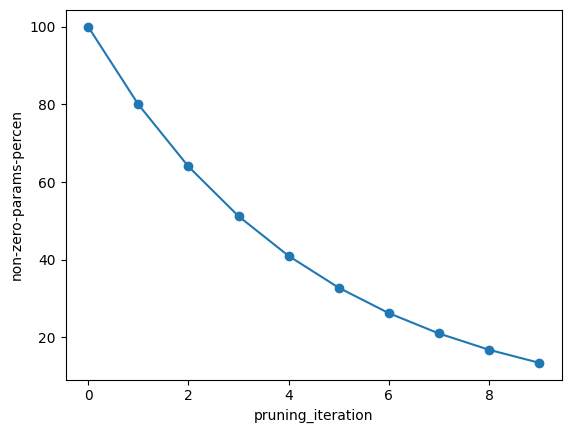

In [43]:
nonzero_param_percent = [100*0.8**i for i in range(10)]
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(nonzero_param_percent,'-o')
ax.set_xlabel('pruning_iteration')
ax.set_ylabel('non-zero-params-percen')

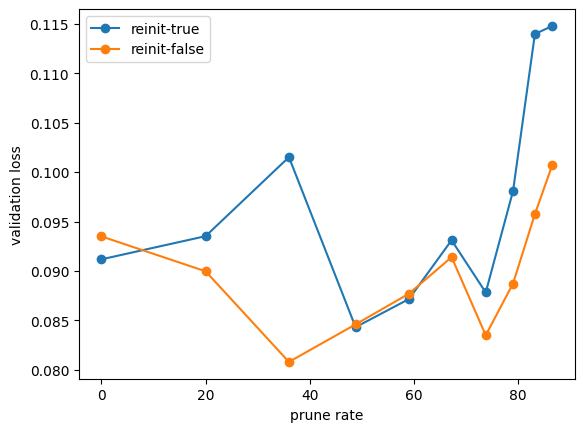

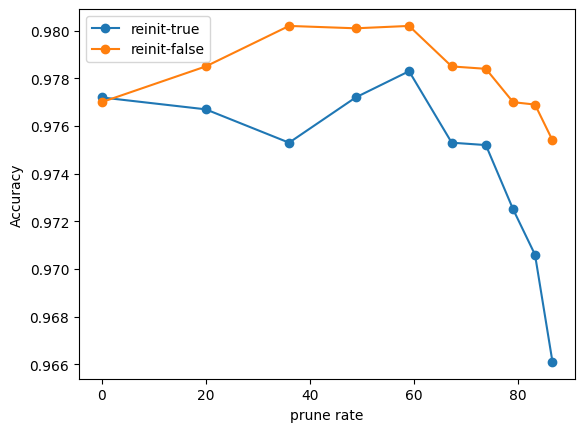

In [44]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_100_0.001_500_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_100_0.001_500_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true,'-o',label='reinit-true')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false,'-o',label='reinit-false')
ax.set_xlabel('prune rate')
ax.set_ylabel('validation loss')
ax.legend()
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinit-true')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='reinit-false')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()